In [73]:
# Load libraries

# Compatibility between Python 2 and Python 3
from __future__ import division, print_function, unicode_literals, absolute_import

%matplotlib inline
import os
import math
import numpy as np
from brian2 import *

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

#from neurodynex.working_memory_network import wm_model
#from neurodynex.working_memory_network import wm_model_modified

from neurodynex.working_memory_network import wm_model_modified_simplified_EC_LV_principal

from neurodynex.tools import plot_tools

from utility_functions import *

import pandas as pd
from scipy.optimize import curve_fit # for doing regression
from sklearn.metrics import r2_score # for measuring fit error

from Python_Libs.utility_functions import *

SAVE_PLOT = False
figs_path = 'Data/Plots/'
figs_extension = '.svg'

figsize = (3.8, 2.6)

# Colour scheme for plots
colourscheme = 'viridis' # 'viridis' or 'none'

if colourscheme == 'viridis':
    viridis = plt.cm.get_cmap('viridis')

if SAVE_PLOT:
    plt.rcParams.update({'font.size': 10}) # Change the font size


In [63]:
def scale_circ_to_line(theta_ts_list, scale=[(0, 360), (0, 100)]):
    """ Gets 
            theta_ts_list   : a list of an numpy array of arrays
            scale           : a list for conversion from a scale to another scale, eg [(0, 360), (0, 100)]
        Returns
            the time series with the samples scaled according to scale, from range scale[0] to range scale[1]
    """
    if isinstance(theta_ts_list, list):
        theta_ts_list = np.array(theta_ts_list)
    if scale is not None: 
        normalised_theta_ts_list = theta_ts_list / scale[0][1] # [0, 1]
        distance_represented = normalised_theta_ts_list * scale[1][1]
    else:
        distance_represented = theta_ts_list
    return distance_represented

def preprocess_time_series(time_series, t_snapshots, scale=None, plot_from_t=None, normalise_start=None):
    """ Gets 
            time_series     : a list or an numpy array of arrays
            t_snapshots     : an array with the time stamps of the samples in time_series (with units)
            scale           : a list for conversion from a scale to another scale, eg [(0, 360), (0, 100)]
            plot_from_t     : return samples from that time stamp onwards
            normalise_start : normalise all time series to this starting value
        Returns
            a touple with the t_snapshots (shortned if plot_from_t != None) and the processed time_series
    """
    # Scale theta degrees to meters
    if scale is not None:
        distance_represented = scale_circ_to_line(time_series, scale)
    else:
        if isinstance(time_series, list):
            time_series = np.array(time_series)
        distance_represented = time_series
    
    if plot_from_t is not None:
        plot_from_t_index = np.argmin(np.abs(t_snapshots - plot_from_t))
    else:
        plot_from_t_index = 0
    
    if normalise_start is not None: 
        # Shift values so that the curve begins at normalise_start
        distance_represented = distance_represented - (distance_represented[plot_from_t_index] - normalise_start)
    
    #return ((t_snapshots/second)[plot_from_t_index:], distance_represented[plot_from_t_index:])
    return (distance_represented[plot_from_t_index:], t_snapshots[plot_from_t_index:])

def calc_theta_mean_absolute_deviation_rate(plot_items_dict, plot_keys_list, start_time=0, end_time=1, percentage=False):
    """ Gets 
            percentile : False for the maximum and minimum sample value or 
                         a number for calculating the median of the first <number>% samples 
                         and the last <number>% samples.
    """
    if isinstance(start_time, Quantity):
        start_time = start_time / second
    if isinstance(end_time, Quantity):
        end_time = end_time / second
    
    for plot_key in plot_keys_list:
        plot_item = plot_items_dict[plot_key]
        if plot_item is not None:
            theta_ts_abs_diff_mean = plot_item['theta_ts_abs_diff_mean']
            t_snapshots = plot_item['t_snapshots']

            if isinstance(t_snapshots, Quantity):
                t_snapshots = t_snapshots / second

            index_start_time = np.argmax(t_snapshots >= start_time)
            index_end_time = np.argmin(t_snapshots <= end_time)
            
            theta_ts_abs_diff_mean_segment = theta_ts_abs_diff_mean[index_start_time:index_end_time]
            if not percentage:
                delta_theta_ts_abs_diff_mean_segment = np.max(theta_ts_abs_diff_mean_segment) - np.min(theta_ts_abs_diff_mean_segment)
            else:
                a = theta_ts_abs_diff_mean_segment
                first_portion_median = np.median(a[0:int(len(a)*percentage/100)])
                last_portion_median = np.median(a[len(a)-int(len(a)*percentage/100):len(a)])
                delta_theta_ts_abs_diff_mean_segment = last_portion_median - first_portion_median
            delta_time = end_time - start_time
            
            theta_mean_absolute_deviation_rate = delta_theta_ts_abs_diff_mean_segment / delta_time
            plot_items_dict[plot_key]['theta_mean_absolute_deviation_rate'] = theta_mean_absolute_deviation_rate
    
    return plot_items_dict

def print_theta_mean_absolute_deviation_rate(plot_items_dict, plot_keys_list, plot_key_str, plot_key_units):
    c1w = max(len(plot_key_str), len(plot_key_units))
    print(('{:^'+str(c1w)+'} {:^10}').format(plot_key_str,  'Drift rate'))
    print(('{:^'+str(c1w)+'} {:^10}').format(plot_key_units, '(°/s)'))
    for plot_key in plot_keys_list:
        plot_item = plot_items_dict[plot_key]
        if plot_item is not None:
            theta_mean_absolute_deviation_rate = plot_item['theta_mean_absolute_deviation_rate']
            print(('{:'+str(c1w)+'} {:10}').format(plot_key, theta_mean_absolute_deviation_rate))


def print_theta_mean_absolute_deviation_rate_scaled(plot_items_dict, plot_keys_list, plot_key_str, plot_key_units, scale=[(0, 360), (0, 100)]):
    c1w = max(len(plot_key_str), len(plot_key_units))
    print(('{:^'+str(c1w)+'} {:^10}').format(plot_key_str,  'Drift rate'))
    print(('{:^'+str(c1w)+'} {:^10}').format(plot_key_units, '(units/s)'))
    for plot_key in plot_keys_list:
        plot_item = plot_items_dict[plot_key]
        if plot_item is not None:
            theta_mean_absolute_deviation_rate = plot_item['theta_mean_absolute_deviation_rate']
            distance_represented_mean_absolute_deviation_rate = scale_circ_to_line(theta_mean_absolute_deviation_rate, scale)
            print(('{:'+str(c1w)+'} {:10}').format(plot_key, distance_represented_mean_absolute_deviation_rate))


In [64]:
def func_lin_1(x, a, b):
    """ Line function """
    y = a * x + b
    return y

def func_exp_1(x, a, b, c):
    """ Exponential function """
    y = a * np.exp(-b*x) + c
    return y

def func_exp_2(x, a, b, c, d):
    """ Exponential function """
    y = d - a * np.exp(-b*x) + c
    return y

def regress(data_x, data_y, func, params0, func_str = None, bounds = (-inf, inf), x_range_min=None, x_range_max=None):
    """
        data_x  : The x data point sample values to fit the function to
        data_y  : The y data point sample values to fit the function to
        func    : Function used for regression
        params0 : Initial guess of function parameter values to optimize
    """
    
    params, conv  = curve_fit(func, data_x, data_y, params0, bounds = bounds) # fit function parameters
    
    # Print the fitted parameters
    if func_str is not None:
        print('Optimal parameters')
        print(func_str.format(params))
    
    # Calculate fitted curve prediction
    y_prime = func(data_x, *params)
    # Calculate r^2
    r2 = r2_score(data_y, y_prime)
    print('R^2 = {}'.format(r2))
    
    # Return a fitted curve for enough sample points to make it smooth for plotting
    if x_range_min is None:
        x_range_min = np.min(data_x)
    if x_range_max is None:
        x_range_max = np.max(data_x)
    # Grenerate x axis values
    x_prime = np.linspace(x_range_min, x_range_max, num=1000, endpoint=True)
    # Calculate fitted curve prediction
    y_prime = func(x_prime, *params)
    
    return x_prime, y_prime, params, r2


In [124]:
input_path = '/Volumes/WD Elements 25A3 Media/Documents/Research/PhD/Projects/Recurrent_Net_Memory/Attractor_Based_Memory_Plaussibility_Study/'
input_file = 'collected-wrapped-NMDA-EC_LV_1.npy' # This is the non unwrapped recordings
input_filename = os.path.join(input_path, input_file)

if os.path.exists(input_filename):
    # Save all data in the file
    data = np.load(input_filename, allow_pickle=True, encoding='bytes')
else: 
    print('ERROR: File does not exist: {:s}'.format(input_filename))

In [66]:
# The above loaded data from the file to the variable data has the following structure:
#     data[()][model][poisson_neuron_noise][neurons_num].keys()    (option 1)
#     data.item()[model][poisson_neuron_noise][neurons_num].keys() (option 2)
#          model = ['NMDA', 'EC_LV_1'][0]
#          poisson_neuron_noise = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009][0]
#          neurons_num = [128, 256, 512, 1024, 2048, 4096, 8192][0]
#  eg data.item()['NMDA'][0.001][1024]['theta_ts_list'] = time_series_collection
# The way to access and explore the dict entries in the the variable data is
#     data[()].keys()
#     or
#     data.item().keys()
model = ['NMDA', 'EC_LV_1'][0]
poisson_neuron_noise = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009][0]
neurons_num = [128, 256, 512, 1024, 2048, 4096, 8192][0]
tau = ['complex', '10m', '50m', '100m', '500m', '1000m', '5000m', '10000m', '50000m'][0]
data.item()[model][poisson_neuron_noise][tau][neurons_num].keys()

dict_keys(['theta_ts_list', 'theta_ts_abs_diff_mean', 'theta_ts_abs_diff_std', 't_snapshots', 'stimulus_center_deg', 'N_excitatory', 'idx_monitored_neurons_excit'])

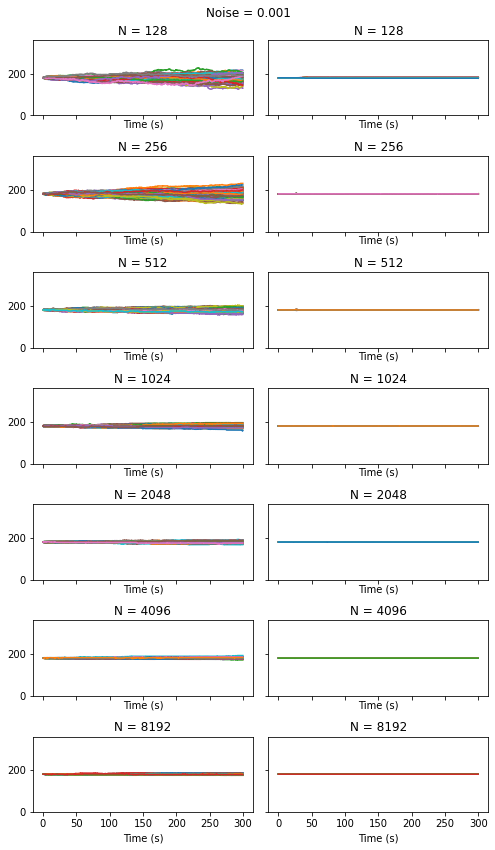

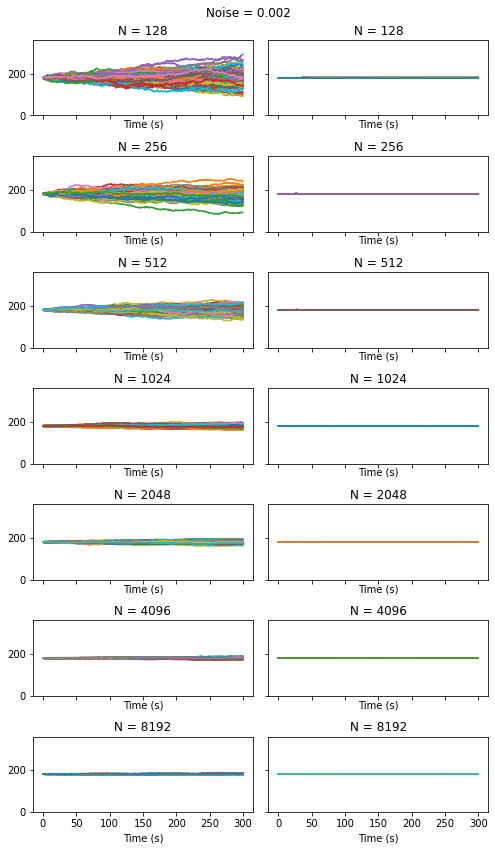

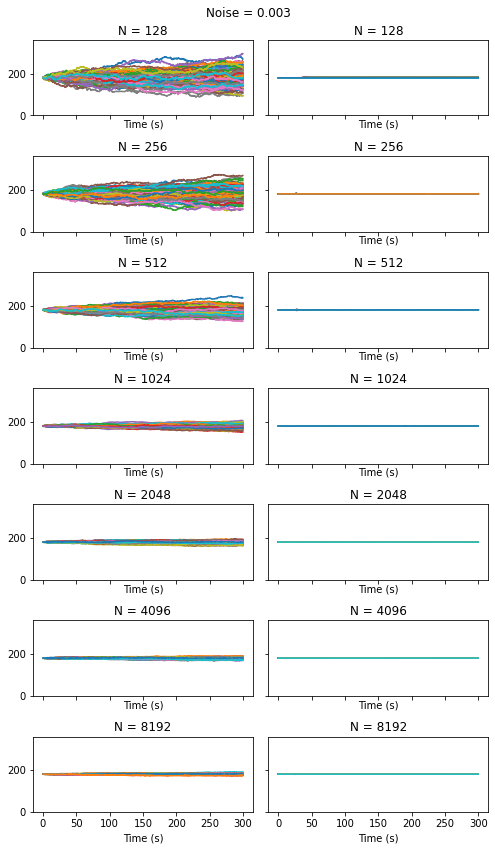

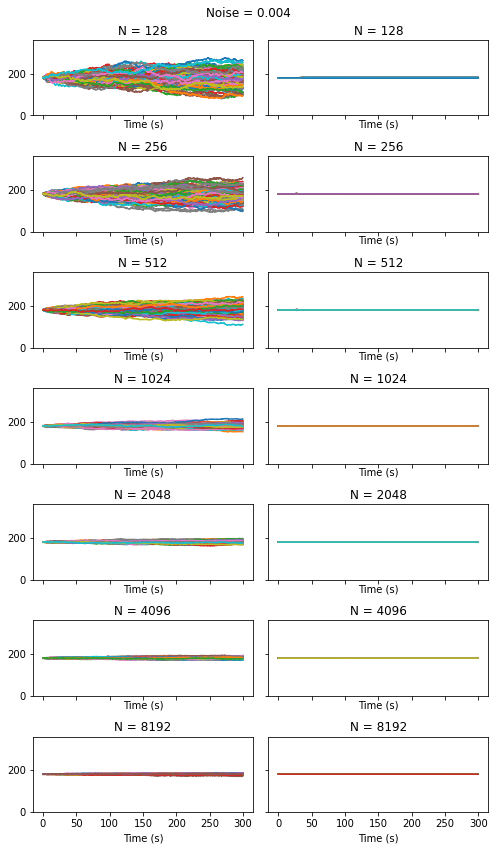

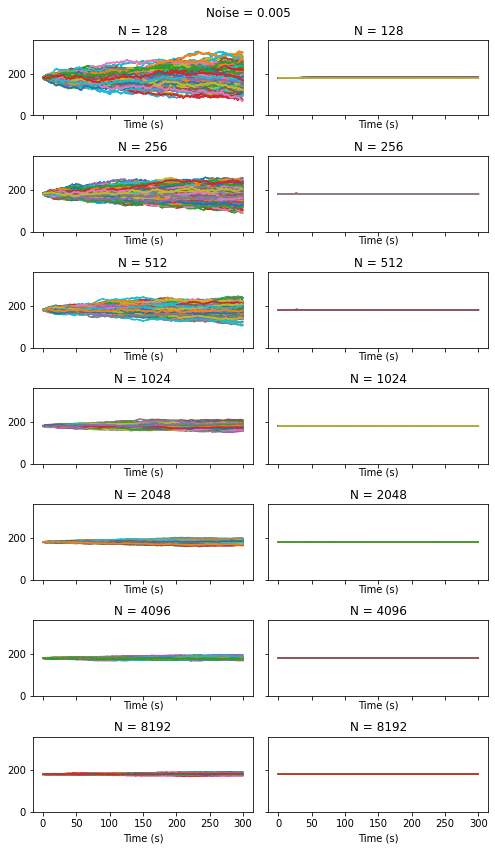

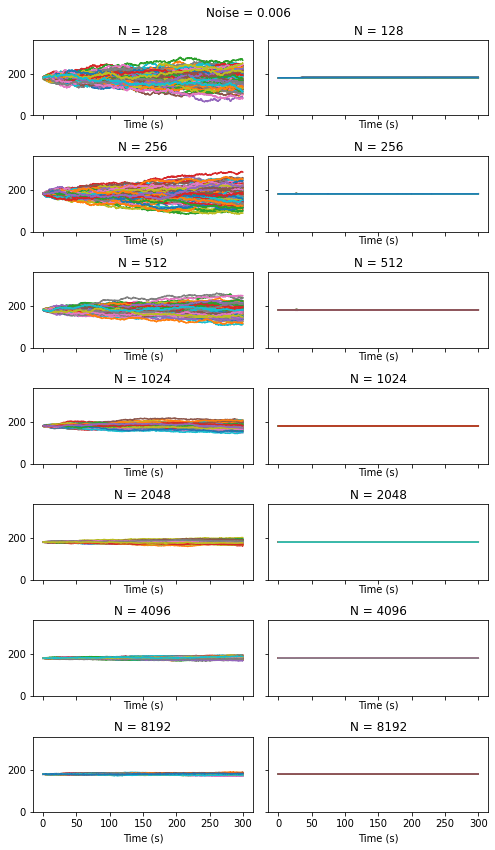

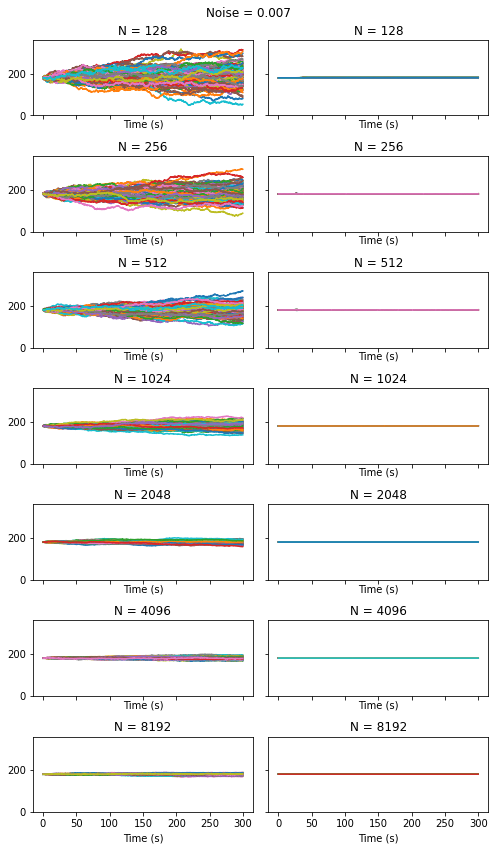

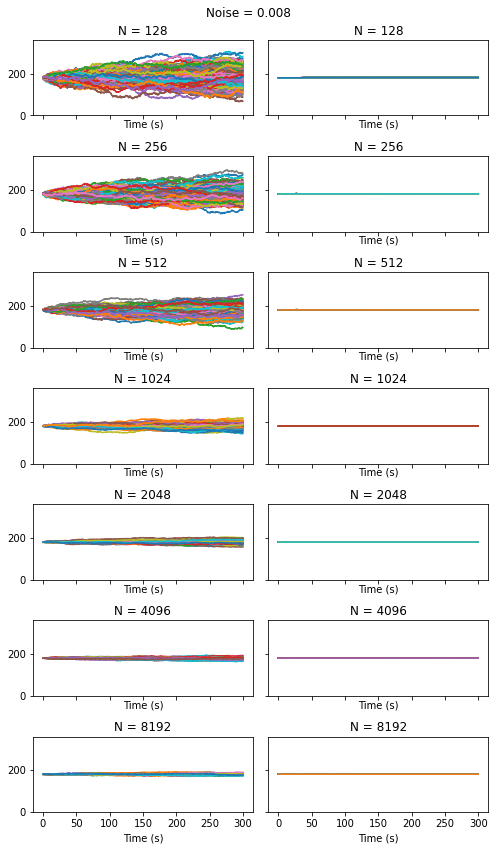

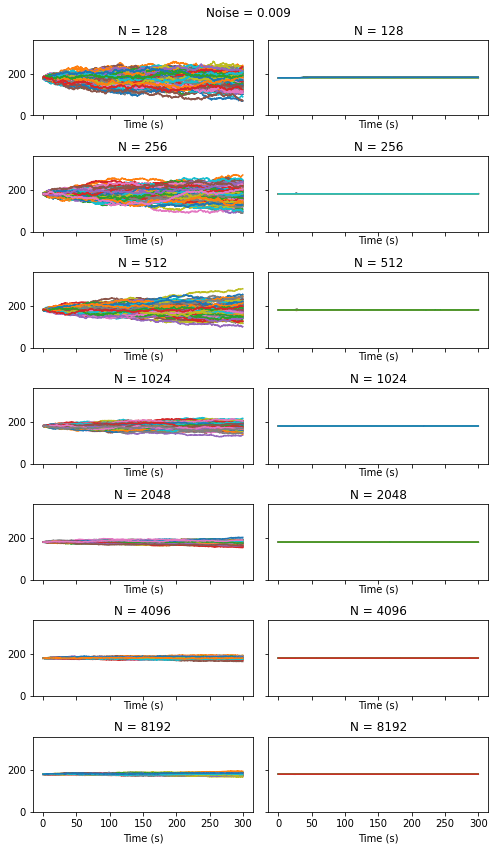

In [6]:
# Plot each experimental condition in separate plot

# Choose what to plot
plot_types = ['theta', 'abs_diff_mean', 'abs_diff_std']
plot_type = plot_types[0]                       # Choose what to plot 
                                                #       'theta': theta_ts_list, 
                                                #       'abs_diff_mean': theta_ts_abs_diff_mean, 
                                                #       'abs_diff_std': theta_ts_abs_diff_std

models = ['NMDA', 'EC_LV_1']  # List of the neuron models present in the collected recordings file
poisson_neuron_noises = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009] # List of the neuron noise present in the collected recordings file
neurons_nums = [128, 256, 512, 1024, 2048, 4096, 8192] # List of the network sizes present in the collected recordings file
taus = ['complex', '10ms', '50ms', '100ms', '500ms', '1000ms', '5000ms', '10000ms', '50000ms']

#model = models[0]                               # Choose which neuron model results to plot
#poisson_neuron_noise = poisson_neuron_noises[0] # Choose what neuron noise results to plot
#neurons_num = neurons_nums[0]                   # Choose which network size results to plot
tau = taus[0]

for poisson_neuron_noise in poisson_neuron_noises:
    fig, axs = plt.subplots(nrows=len(neurons_nums), ncols=2, figsize=(7, 12), sharex=True, sharey=True)

    for indx_i, model in enumerate(models):
        for indx_j, neurons_num in enumerate(neurons_nums):
            # Get reference to the appropriate subplot
            ax = axs[indx_j, indx_i]
            # Get the list of theta recordings time series
            theta_ts_list = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_list']
            t_snapshots = data[()][model][poisson_neuron_noise][tau][neurons_num]['t_snapshots']
            theta_ts_abs_diff_mean = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_abs_diff_mean']
            theta_ts_abs_diff_std = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_abs_diff_std']

            fig.suptitle('Noise = ' + str(poisson_neuron_noise))

            if plot_type == plot_types[0]: # Plot theta_ts_list
                for i, ts in enumerate(theta_ts_list):
                    ax.plot(t_snapshots, ts)
                    ax.set_title('N = ' + str(neurons_num))
                    ax.set_xlabel('Time (s)')
                    ax.set_ylim((0, 360))

            if plot_type == plot_types[1]: # Plot theta_ts_abs_diff_mean
                ax.plot(t_snapshots, theta_ts_abs_diff_mean)
                ax.set_title('N = ' + str(neurons_num))
                ax.set_xlabel('Time (s)')
                #ax.set_ylim((0, 360))

            if plot_type == plot_types[2]: # Plot theta_ts_abs_diff_std
                ax.plot(t_snapshots, theta_ts_abs_diff_std)
                ax.set_title('N = ' + str(neurons_num))
                ax.set_xlabel('Time (s)')
                #ax.set_ylim((0, 360))

    fig.tight_layout()

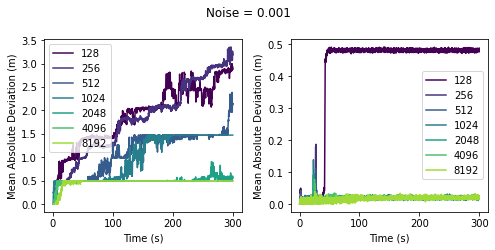

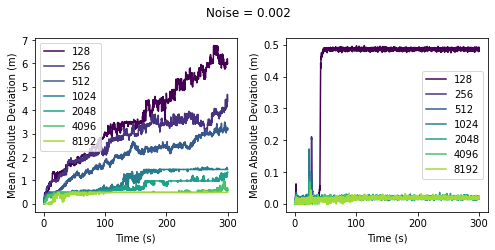

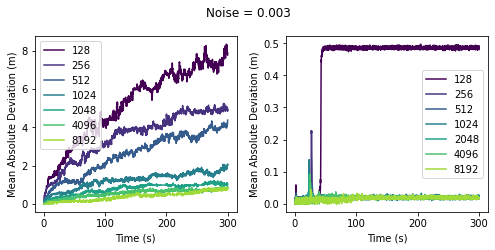

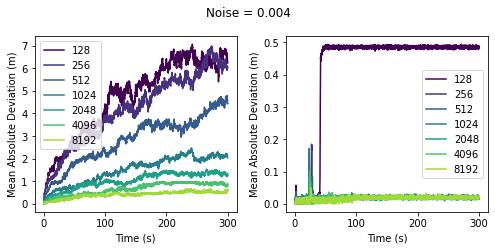

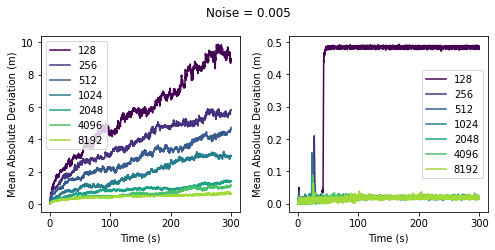

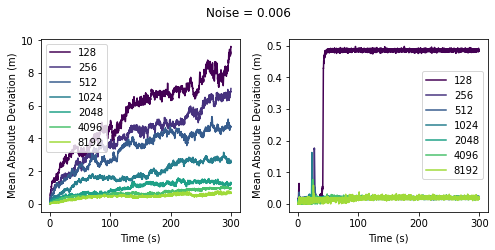

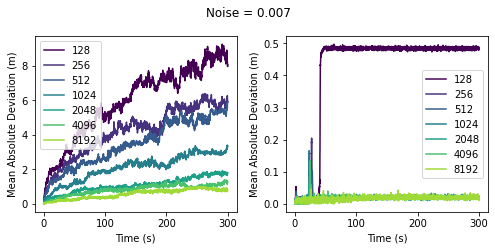

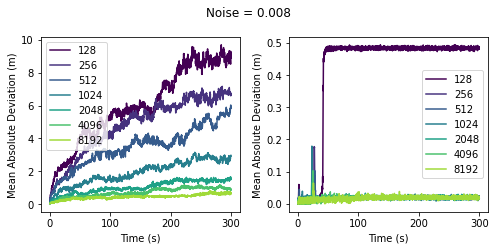

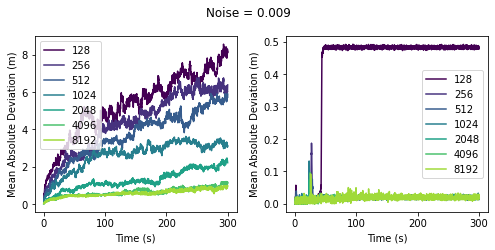

In [18]:
# Plot experimental conditions collated in combined plots
# Noise = 0.005 seems to be a nice choise
# The jump at the EC_LV_1 with N=128 corresponds to 0.622 neurons, so it is a jump to the middle in average

# Choose what to plot
plot_types = ['theta', 'abs_diff_mean', 'abs_diff_std']
plot_type = plot_types[1]                       # Choose what to plot 
                                                #       'theta': theta_ts_list, (In this version there is not much point of using this option because it will plot all network sizes in the same plot)
                                                #       'abs_diff_mean': theta_ts_abs_diff_mean, 
                                                #       'abs_diff_std': theta_ts_abs_diff_std

models = ['NMDA', 'EC_LV_1']  # List of the neuron models present in the collected recordings file
poisson_neuron_noises = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009] # List of the neuron noise present in the collected recordings file
neurons_nums = [128, 256, 512, 1024, 2048, 4096, 8192] # List of the network sizes present in the collected recordings file
taus = ['complex', '10ms', '50ms', '100ms', '500ms', '1000ms', '5000ms', '10000ms', '50000ms']

#model = models[0]                               # Choose which neuron model results to plot
#poisson_neuron_noise = poisson_neuron_noises[0] # Choose what neuron noise results to plot
#neurons_num = neurons_nums[0]                   # Choose which network size results to plot
tau = taus[0]

# Mapping of the time series into a custom range (from theta={0,360} to eg m={0,100})
plot_mapping_units = 'Mean Absolute Deviation (m)'
plot_scale_mapping = [(0, 360), (0, 100)]
normalise_start = None
plot_from_t = None

for poisson_neuron_noise in poisson_neuron_noises:
    if SAVE_PLOT:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 3), sharex=True, sharey=True)
    else:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 3.5), sharex=True, sharey=False)

    for indx_i, model in enumerate(models):
        for indx_j, neurons_num in enumerate(neurons_nums):
            # Get reference to the appropriate subplot
            ax = axs[indx_i]
            # Get the list of theta recordings time series
            theta_ts_list = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_list']
            t_snapshots = data[()][model][poisson_neuron_noise][tau][neurons_num]['t_snapshots']
            theta_ts_abs_diff_mean = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_abs_diff_mean']
            theta_ts_abs_diff_std = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_abs_diff_std']
            
            if not SAVE_PLOT:
                fig.suptitle('Noise = ' + str(poisson_neuron_noise))
            
            # In this version there is not much point of using this option because it will plot all network sizes in the same plot
            if plot_type == plot_types[0]: # Plot theta_ts_list
                ts_list, t_snaps = preprocess_time_series(theta_ts_list, t_snapshots, scale=plot_scale_mapping, plot_from_t=None, normalise_start=None)
                for i, ts in enumerate(ts_list):
                    ax.plot(t_snaps/second, ts)
                    ax.set_title('N = ' + str(neurons_num))
                    ax.set_xlabel('Time (s)')
                    #ax.set_ylim((0, 360))
                    ax.set_ylabel(plot_mapping_units)

            if plot_type == plot_types[1]: # Plot theta_ts_abs_diff_mean
                ts_list, t_snaps = preprocess_time_series(theta_ts_abs_diff_mean, t_snapshots, scale=plot_scale_mapping, plot_from_t=None, normalise_start=None)
                if colourscheme == 'viridis': 
                    colour = viridis(indx_j/len(neurons_nums))
                    ax.plot(t_snaps/second, ts_list, label=str(neurons_num), color=colour)
                else: 
                    ax.plot(t_snaps/second, ts_list, label=str(neurons_num))
                #ax.set_title('N = ' + str(neurons_num))
                ax.set_xlabel('Time (s)')
                ax.set_ylabel(plot_mapping_units)
                #ax.set_ylim((0, 360))
                ax.legend()

            if plot_type == plot_types[2]: # Plot theta_ts_abs_diff_std
                ts_list, t_snaps = preprocess_time_series(theta_ts_abs_diff_std, t_snapshots, scale=plot_scale_mapping, plot_from_t=None, normalise_start=None)
                if colourscheme == 'viridis': 
                    colour = viridis(indx_j/len(neurons_nums))
                    ax.plot(t_snaps/second, ts_list, label=str(neurons_num), color=colour)
                else:
                    ax.plot(t_snaps/second, ts_list, label=str(neurons_num))
                #ax.set_title('N = ' + str(neurons_num))
                ax.set_xlabel('Time (s)')
                ax.set_ylabel(plot_mapping_units)
                #ax.set_ylim((0, 360))
                ax.legend()
            #if indx_i == 1:
            #    ax.set_ylim([0, 0.04])
    fig.tight_layout()
    
    if SAVE_PLOT:
        fig.savefig(os.path.join(figs_path, 'pub_effect_of_net_size_on_dispersion_range100m' + '_noise' + str(poisson_neuron_noise) + figs_extension), bbox_inches='tight', dpi=300)
        

Noise = 0.005
N = 256
ts_list len =  249


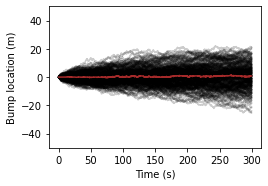

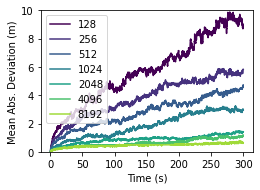

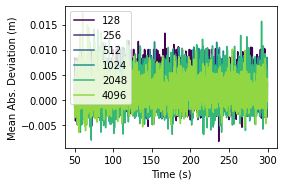

In [134]:
# Plot experimental conditions collated in combined plots
# Noise = 0.005 seems to be a nice choise
# The jump at the EC_LV_1 with N=128 corresponds to 0.622 neurons, so it is a jump to the middle in average

# Choose what to plot
plot_types = ['theta', 'abs_diff_mean', 'abs_diff_std']
plot_type = plot_types[1]                       # Choose what to plot 
                                                #       'theta': theta_ts_list, (In this version there is not much point of using this option because it will plot all network sizes in the same plot)
                                                #       'abs_diff_mean': theta_ts_abs_diff_mean, 
                                                #       'abs_diff_std': theta_ts_abs_diff_std

def plot_individual_traces(ax, data_dic, scale, plot_type, y_bias=0, xlabel='Time (s)', ylabel='y label', plot_traces_subset=None, colourscheme=None, colour=None, alpha=0.2, plot_median=False, colour_median='black', SAVE_PLOT=False):
    """
        plot_traces_subset : If None plot all traces, 
                             if an integer plot only the first as many traces [:plot_traces_subset], 
                             if a list of two items use it as a slice and plot the sliced traces.
    """
    # Get the list of theta recordings time series
    theta_ts_list = data_dic['theta_ts_list']
    t_snapshots = data_dic['t_snapshots']
    theta_ts_abs_diff_mean = data_dic['theta_ts_abs_diff_mean']
    theta_ts_abs_diff_std = data_dic['theta_ts_abs_diff_std']

    if colourscheme == 'viridis':
        viridis = plt.cm.get_cmap('viridis')

    # In this version there is not much point of using this option because it will plot all network sizes in the same plot
    if plot_type == 'theta': # Plot theta_ts_list
        ts_list, t_snaps = preprocess_time_series(theta_ts_list, t_snapshots, scale=plot_scale_mapping, plot_from_t=None, normalise_start=None)
        if plot_traces_subset is not None:
            if isinstance(plot_traces_subset, int):
                ts_list = ts_list[:plot_traces_subset]
            elif isinstance(plot_traces_subset, list) and len(plot_traces_subset) == 2:
                ts_list = ts_list[slice(*plot_traces_subset)]
        for i, ts in enumerate(ts_list):
            if colourscheme == 'viridis': 
                colour = viridis(indx_j/len(neurons_nums))
                ax.plot(t_snaps/second, ts+y_bias, color=colour)
            else:
                ax.plot(t_snaps/second, ts+y_bias, color=colour, alpha=alpha)
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
        print('ts_list len = ', len(ts_list))
        
        if plot_median:
            ax.plot(t_snaps/second, np.median(ts_list, axis=0)+y_bias, color=colour_median)


def plot_abs_diff_mean(ax, data_dic, scale, plot_type, neurons_nums, xlabel='Time (s)', ylabel='y label', plot_from_t=None, normalise_start=None, colourscheme=None, SAVE_PLOT=False):
    if colourscheme == 'viridis':
        viridis = plt.cm.get_cmap('viridis')

    # Get the list of theta recordings time series
    for indx_j, neurons_num in enumerate(neurons_nums):
        theta_ts_list = data_dic[neurons_num]['theta_ts_list']
        t_snapshots = data_dic[neurons_num]['t_snapshots']
        theta_ts_abs_diff_mean = data_dic[neurons_num]['theta_ts_abs_diff_mean']
        theta_ts_abs_diff_std = data_dic[neurons_num]['theta_ts_abs_diff_std']

        if plot_type == 'abs_diff_mean': # Plot theta_ts_abs_diff_mean
            ts_list, t_snaps = preprocess_time_series(theta_ts_abs_diff_mean, t_snapshots, scale=plot_scale_mapping, plot_from_t=plot_from_t, normalise_start=normalise_start)
            if colourscheme == 'viridis': 
                colour = viridis(indx_j/len(neurons_nums))
                ax.plot(t_snaps/second, ts_list, label=str(neurons_num), color=colour)
            else: 
                ax.plot(t_snaps/second, ts_list, label=str(neurons_num))

        if plot_type == 'abs_diff_std': # Plot theta_ts_abs_diff_std
            ts_list, t_snaps = preprocess_time_series(theta_ts_abs_diff_std, t_snapshots, scale=plot_scale_mapping, plot_from_t=plot_from_t, normalise_start=normalise_start)
            if colourscheme == 'viridis': 
                colour = viridis(indx_j/len(neurons_nums))
                ax.plot(t_snaps/second, ts_list, label=str(neurons_num), color=colour)
            else:
                ax.plot(t_snaps/second, ts_list, label=str(neurons_num))
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()


models = ['NMDA', 'EC_LV_1']  # List of the neuron models present in the collected recordings file
poisson_neuron_noises = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009] # List of the neuron noise present in the collected recordings file
neurons_nums = [128, 256, 512, 1024, 2048, 4096, 8192] # List of the network sizes present in the collected recordings file
taus = ['complex', '10ms', '50ms', '100ms', '500ms', '1000ms', '5000ms', '10000ms', '50000ms']

model = models[0]  # List of the neuron models present in the collected recordings file
poisson_neuron_noise = 0.005 # The neuron noise present in the collected recordings file
neurons_num = 256 # The network sizes present in the collected recordings file
taus = ['complex', '10ms', '50ms', '100ms', '500ms', '1000ms', '5000ms', '10000ms', '50000ms']
tau = taus[0]
plot_traces_subset = None # None for plotting all traces, if a number plots that many first traces

# Mapping of the time series into a custom range (from theta={0,360} to eg m={0,100})
plot_scale_mapping = [(0, 360), (0, 100)]
normalise_start = None
plot_from_t = None


print('Noise = ' + str(poisson_neuron_noise))
print('N = ' + str(neurons_num))
model = ['NMDA', 'EC_LV_1'][0]
data_dic = data[()][model][poisson_neuron_noise][tau][neurons_num]
plot_type = ['theta', 'abs_diff_mean', 'abs_diff_std'][0]
fig = plt.figure(figsize=figsize)
ax = plt.gca()
plot_individual_traces(ax, data_dic, scale=plot_scale_mapping, plot_type=plot_type, y_bias=-50, ylabel = 'Bump location (m)', plot_traces_subset=plot_traces_subset, colour='black', SAVE_PLOT=SAVE_PLOT, alpha=0.2, plot_median=True, colour_median='brown')
#ax.set_ylim([0, 100])
ax.set_ylim([-50, 50])

if SAVE_PLOT:
    fig.savefig(os.path.join(figs_path, 'pub_' + model + '_bump_dispersion_traces_range100m' + '_neurons' + str(neurons_num) + '_noise' + str(poisson_neuron_noise) + figs_extension), bbox_inches='tight', dpi=300)

model = ['NMDA', 'EC_LV_1'][0]
data_dic = data[()][model][poisson_neuron_noise][tau]
plot_type = ['theta', 'abs_diff_mean', 'abs_diff_std'][1]
fig = plt.figure(figsize=figsize)
ax = plt.gca()
plot_abs_diff_mean(ax, data_dic, scale=plot_scale_mapping, plot_type=plot_type, neurons_nums=neurons_nums, ylabel = 'Mean Abs. Deviation (m)', colourscheme='viridis', SAVE_PLOT=SAVE_PLOT)
ax.set_ylim([0, 10])

if SAVE_PLOT:
    fig.savefig(os.path.join(figs_path, 'pub_' + model + '_effect_of_net_size_on_dispersion_range100m' + '_noise' + str(poisson_neuron_noise) + figs_extension), bbox_inches='tight', dpi=300)

model = ['NMDA', 'EC_LV_1'][1]
data_dic = data[()][model][poisson_neuron_noise][tau]
plot_type = ['theta', 'abs_diff_mean', 'abs_diff_std'][1]
neurons_nums = [128, 256, 512, 1024, 2048, 4096] # List of the network sizes present in the collected recordings file
fig = plt.figure(figsize=figsize)
ax = plt.gca()
plot_abs_diff_mean(ax, data_dic, scale=plot_scale_mapping, plot_type=plot_type, neurons_nums=neurons_nums, ylabel = 'Mean Abs. Deviation (m)', plot_from_t=50*second, normalise_start=0, colourscheme='viridis', SAVE_PLOT=SAVE_PLOT)
#ax.set_ylim([0, 10])
#ax.set_ylim([0, 0.1])

if SAVE_PLOT:
    fig.savefig(os.path.join(figs_path, 'pub_' + model + '_effect_of_net_size_on_dispersion_range100m' + '_noise' + str(poisson_neuron_noise) + figs_extension), bbox_inches='tight', dpi=300)


In [131]:
neurons_nums = [128, 256, 512, 1024, 2048, 4096, 8192] # List of the network sizes present in the collected recordings file
results_data = {}
for poisson_neuron_noise in poisson_neuron_noises:
    # Collect data for plot
    results_data[poisson_neuron_noise] = dict()
    print()
    print('Noise = ' + str(poisson_neuron_noise))
    for indx_i, model in enumerate(models):
        print()
        print(model + ' neuron model')
        print('=====================')
        trials_dict = data[()][model][poisson_neuron_noise][tau]
        trials_dict_ammended = calc_theta_mean_absolute_deviation_rate(trials_dict, neurons_nums, start_time=0, end_time=200, percentage=0.1)
        print('---------------------')
        print('Not scaled output')
        print('---------------------')
        print_theta_mean_absolute_deviation_rate(trials_dict_ammended, neurons_nums, plot_key_str='Neurons', plot_key_units='number')
        #print_theta_mean_absolute_deviation_rate(trials_dict_ammended, neurons_nums, plot_key_str='Noise', plot_key_units='(1/SNR)')
        print('---------------------')
        print('Scaled output')
        print('---------------------')
        print_theta_mean_absolute_deviation_rate_scaled(trials_dict_ammended, neurons_nums, scale=[(0, 360), (0, 100)], plot_key_str='Neurons', plot_key_units='number')

        # Collect data for plot
        results_data[poisson_neuron_noise][model] = dict()
        results_data[poisson_neuron_noise][model]['x'] = []
        results_data[poisson_neuron_noise][model]['y'] = []
        for neurons_num in neurons_nums:
            results_data[poisson_neuron_noise][model]['x'].append(neurons_num)
            results_data[poisson_neuron_noise][model]['y'].append(trials_dict_ammended[neurons_num]['theta_mean_absolute_deviation_rate'])



Noise = 0.001

NMDA neuron model
---------------------
Not scaled output
---------------------
Neurons Drift rate
number    (°/s)   
    128 0.043680215363300266
    256 0.03757615646019708
    512 0.024892136708993037
   1024 0.026470588235293774
   2048 0.00882352941176464
   4096 0.00882352941176464
   8192 0.008823529411764355
---------------------
Scaled output
---------------------
Neurons Drift rate
number  (units/s) 
    128 0.012133393156472296
    256 0.010437821238943634
    512 0.006914482419164732
   1024 0.007352941176470493
   2048 0.0024509803921568445
   4096 0.0024509803921568445
   8192 0.0024509803921567656

EC_LV_1 neuron model
---------------------
Not scaled output
---------------------
Neurons Drift rate
number    (°/s)   
    128 0.008677845798198547
    256 0.0003307829440730359
    512 0.0003396533492142595
   1024 0.00039297812347399485
   2048 0.00031399072902871695
   4096 6.578317838958014e-05
   8192 0.00038481835768386927
---------------------
Scaled o

Max tolerable drift rate 0.034m/h (9.444444444444445e-06m/s)
Optimal parameters
y=a*exp(-b*x)+c, [a, b, c] = [46969.25313224   746.37823886   458.9775283 ]
R^2 = 0.9850411809124867
For ensuring drift of less than 0.034m/h (9.444444444444445e-06m/s) we need 47098 excitatory neurons
Optimal parameters
y=a*exp(-b*x)+c, [a, b, c] = [4.57660138e+03 6.87836485e+03 2.47305700e+00]
R^2 = 0.19796773169836457
For ensuring drift of less than 0.034m/h (9.444444444444445e-06m/s) we need 4291 excitatory neurons


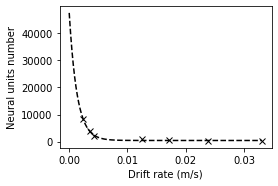

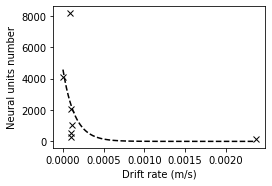

In [139]:
# New attempt
# Fit curves to the data points
# Drift rate in meters/sec

#plt.rcParams.update({'font.size': 14}) # Change the font size

# Requirements calculation:
t_req = 60 * 60 # Default t_req = 1h
drift_max_percent = 0.01 # Default 1%

# Set condition
condition = 2 # condition = 1 or 2: 1 is for 1m/100m while 2 for 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)
if condition == 1:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.01 # 1% => 1m/100m
if condition == 2:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.00034 # 0.034% => 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)

range_max = 360
range_max_new = 100

drift_max = drift_max_percent * range_max_new
drift_rate_max = drift_max / t_req
x_req = drift_rate_max
print('Max tolerable drift rate {}m/h ({}m/s)'.format(drift_max, drift_rate_max))

def func_exp(x, a, b, c):
    """ Exponential function """
    y = a * np.exp(-b*x) + c
    return y

# Plot only for 0.005 synaptic noise
poisson_neuron_noise = 0.005

for indx_i, model in enumerate(models):

    fig = plt.figure(figsize=figsize)
    
    x = np.array(results_data[poisson_neuron_noise][model]['y'])
    y = np.array(results_data[poisson_neuron_noise][model]['x'])
    x = scale_circ_to_line(x, scale=[(0, range_max), (0, range_max_new)])
    
    params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA':
        params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'EC_LV_1':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    
    params, conv  = curve_fit(func_exp, x, y, params0) # fit function parameters

    # Print the fitted parameters
    print('Optimal parameters')
    print('y=a*exp(-b*x)+c, [a, b, c] = {}'.format(params))

    # Calculate fitted curve prediction
    y_prime = func_exp(x, params[0], params[1], params[2])

    # Calculate r^2
    print('R^2 = {}'.format(r2_score(y, y_prime)))

    # Calculate required number of neurons
    y_req = func_exp(x_req, params[0], params[1], params[2])
    print('For ensuring drift of less than {}m/h ({}m/s) we need {} excitatory neurons'.format(drift_max, x_req, int(np.round(y_req))))

    # Plot data points
    #plt.plot(x, y, linestyle='', marker='.', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.plot(x, y, 'xk', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')

    # Plot fitted curve for more sample points to make it smooth
    #x_prime = np.linspace(np.min(x), np.max(x), num=1000, endpoint=True)
    max_lim = 1
    max_lim = np.max(x)
    x_prime = np.linspace(0, max_lim, num=1000, endpoint=True)

    # Calculate fitted curve prediction
    y_prime = func_exp(x_prime, params[0], params[1], params[2])
    #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.plot(x_prime, y_prime, '--k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')

    # 
    #plt.legend(loc='best')
    plt.xlabel('Drift rate (m/s)')
    plt.ylabel('Neural units number')
    #plt.xlim([0, max_lim])
    
    if SAVE_PLOT:
        #plt.savefig(os.path.join('Data/Plots/', 'pub_' + model + '_net_size_vs_dispersion_rate_range' + str(range_max_new) + 'm' + figs_extension), bbox_inches='tight', dpi=300)
        fig.savefig(os.path.join('Data/Plots/', 'pub_' + model + '_net_size_vs_dispersion_rate_range' + str(range_max_new) + 'm' + '_noise' + str(poisson_neuron_noise) + figs_extension), bbox_inches='tight', dpi=300)
    

### For the EC_LV_1 neurons for more than 128 neurons any number of neurons does not produce significant difference in drift so all measurements appear vertically the one above the other so no good fitting can be made and it is not meaningfull. Because of this behaviour using the percentage value in the calc_theta_mean_absolute_deviation_rate() call produces wildly varying results. It works though as expected for the NMDA neurons. 

In [41]:
#import pandas as pd
#import copy 
## Reformat to 3D dict
#results_data_3D = copy.deepcopy(results_data)
#for k1 in results_data_3D.keys():
#    for k2 in results_data_3D[k1].keys():
#        for k_i, val in enumerate(results_data_3D[k1][k2]['x']):
#            results_data_3D[k1][k2][val] = scale_circ_to_line(results_data_3D[k1][k2]['y'][k_i], scale=[(0, 360), (0, 100)])
#        del results_data_3D[k1][k2]['x']
#        del results_data_3D[k1][k2]['y']
#
## Load the dict into a pandas data frame
## The dict structure is 
##     results_data_3D[poisson_neuron_noise][model][neurons_num] = drift_MAD_float
#df = pd.concat({k: pd.DataFrame(v).T for k, v in results_data_3D.items()}, axis=0)
#
## Set index names
#df.index.names = ['Noise', 'Model']
#df = df.reorder_levels(['Model', 'Noise'])
#
## Not sure how to do this; Scale the Noise values to the actual per neuron *1000
##df['Noise'] = df['Noise'].apply(lambda x: x*1000)
#
##df.columns.tolist()
#
## Sort index
#df.sort_index(inplace=True)
#df

In [128]:
import pandas as pd
import copy 
# Reformat to 3D dict
results_data_3D = []
for k1 in results_data.keys():
    for k2 in results_data[k1].keys():
        for k_i, key in enumerate(results_data[k1][k2]['x']):
            results_data_3D.append([k1, key, k2, scale_circ_to_line(results_data[k1][k2]['y'][k_i], scale=[(0, 360), (0, 100)])])
#results_data_3D
df4 = pd.DataFrame(results_data_3D, columns=['Noise', 'Neurons', 'Model', 'Drift'])
df4.set_index(['Model', 'Neurons'], inplace=True)

df4

Noise     Drift
Model   Neurons                 
NMDA    128      0.001  0.012133
        256      0.001  0.010438
        512      0.001  0.006914
        1024     0.001  0.007353
        2048     0.001  0.002451
...                ...       ...
EC_LV_1 512      0.009  0.000094
        1024     0.009  0.000072
        2048     0.009  0.000084
        4096     0.009  0.000080
        8192     0.009  0.000129

[126 rows x 2 columns]

WARNING    /Users/john/Library/Python/3.7/lib/python/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
 [py.warnings]
WARNING    /Users/john/Library/Python/3.7/lib/python/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
 [py.warnings]
WARNING    /Users/john/Library/Python/3.7/lib/python/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
 [py.warnings]
WARNING    /Users/john/Library/Python/3.7/lib/python/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
 [py.warnings]


Optimal parameters
d - a*exp(-b*x)+c, [a, b, c, d] = [ 6.21168082e-02  1.06375809e+03 -6.68209374e+03  6.68212694e+03]
R^2 = 0.9171745998947933
Optimal parameters
d - a*exp(-b*x)+c, [a, b, c, d] = [ 3.37629750e-02  7.29416525e+02  4.64869285e+03 -4.64866634e+03]
R^2 = 0.9320515907189519
Optimal parameters
d - a*exp(-b*x)+c, [a, b, c, d] = [ 2.56287183e-02  5.31446104e+02 -7.00999893e+04  7.01000112e+04]
R^2 = 0.8270222385929104
Optimal parameters
d - a*exp(-b*x)+c, [a, b, c, d] = [ 9.48211253e-03  1.39309069e+02  2.99000075e+04 -2.98999926e+04]
R^2 = 0.601336119590417
Optimal parameters
d - a*exp(-b*x)+c, [a, b, c, d] = [ 6.23647265e-03  3.27711072e+02  9.90000547e+03 -9.89999817e+03]
R^2 = 0.673043233316909
Optimal parameters
d - a*exp(-b*x)+c, [a, b, c, d] = [ 2.88382638e-03  6.65310925e+02 -3.00999970e+04  3.01000009e+04]
R^2 = 0.3260038785789926
Optimal parameters
d - a*exp(-b*x)+c, [a, b, c, d] = [-1.99812065e-04  3.32310229e+03  2.11871807e+04 -2.11871780e+04]
R^2 = -0.0013785654

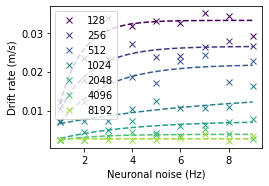

In [43]:
#df4.xs('NMDA').plot()
#df4.xs('NMDA').plot(x='Noise', y='Drift')
#df4.xs('NMDA').loc[128]['Noise']
#df4.xs('NMDA').loc[128]['Drift']

model = 'NMDA'

fig = plt.figure(figsize=figsize)
# Get the unique list of Neurons values and iterate
for indx_i, neurons in enumerate(np.unique(df4.xs(model).index.values)):
    # For each Neurons value plot a Drift vs Noise plot
    x = df4.xs(model).loc[neurons]['Noise']
    y = df4.xs(model).loc[neurons]['Drift']
    x_prime, y_prime, params, r2 = regress(x, y, func_exp_2, [0.06, 1000.0, -100, 100], func_str = 'd - a*exp(-b*x)+c, [a, b, c, d] = {}')
    if colourscheme == 'viridis': 
        colour = viridis(indx_i/len(neurons_nums))
        plt.plot(x*1000, y, 'x', label=neurons, color=colour)
        plt.plot(x_prime*1000, y_prime, '--', color=colour)
    else:
        plt.plot(x*1000, y, 'x', label=neurons)
        plt.plot(x_prime*1000, y_prime, '--')
plt.legend()
plt.xlabel('Neuronal noise (Hz)')
plt.ylabel('Drift rate (m/s)')

#fig.tight_layout()

if SAVE_PLOT:
    fig.savefig(os.path.join(figs_path, 'pub_' + str(model) + '_effect_of_neuronal_noise_on_dispersion_rate_range100m' + figs_extension), bbox_inches='tight', dpi=300)


Optimal parameters
a*x + b, [a, b] = [-0.00095526  0.00239384]
R^2 = 0.007896786397400435
Optimal parameters
a*x + b, [a, b] = [1.92142241e-04 9.49051364e-05]
R^2 = 0.013282931279982924
Optimal parameters
a*x + b, [a, b] = [-5.74039941e-05  9.38944777e-05]
R^2 = 0.0004886862871695818
Optimal parameters
a*x + b, [a, b] = [-0.00471639  0.00011768]
R^2 = 0.5535835350729872
Optimal parameters
a*x + b, [a, b] = [3.46360543e-04 9.16910329e-05]
R^2 = 0.018681035951013336
Optimal parameters
a*x + b, [a, b] = [5.66450990e-03 1.25527274e-05]
R^2 = 0.1882178226500123
Optimal parameters
a*x + b, [a, b] = [6.59713211e-04 9.04627055e-05]
R^2 = 0.011687361074450231


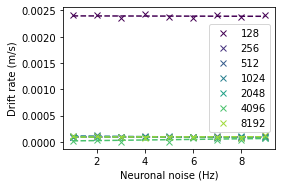

In [129]:
model = 'EC_LV_1'

fig = plt.figure(figsize=figsize)

for indx_i, neurons in enumerate(np.unique(df4.xs(model).index.values)):
    # For each Neurons value plot a Drift vs Noise plot
    x = df4.xs(model).loc[neurons]['Noise']
    y = df4.xs(model).loc[neurons]['Drift']
    # Both the exponential and linear function regression give equally bad R^2 score
    #x_prime, y_prime = regress(x, y, func_exp_2, [0.06, 1.0, -1.0, 1.0], func_str = 'a*exp(-b*x)+c, [a, b, c] = {}')
    x_prime, y_prime, params, r2 = regress(x, y, func_lin_1, [0.01, 0.0], func_str = 'a*x + b, [a, b] = {}')
    if colourscheme == 'viridis': 
        colour = viridis(indx_i/len(neurons_nums))
        plt.plot(x*1000, y, 'x', label=neurons, color=colour)
        plt.plot(x_prime*1000, y_prime, '--', color=colour)
    else:
        plt.plot(x*1000, y, 'x', label=neurons)
        plt.plot(x_prime*1000, y_prime, '--')
plt.legend()
plt.xlabel('Neuronal noise (Hz)')
plt.ylabel('Drift rate (m/s)')

#fig.tight_layout()

if SAVE_PLOT:
    fig.savefig(os.path.join(figs_path, 'pub_' + str(model) + '_effect_of_neuronal_noise_on_dispersion_rate_range100m' + figs_extension), bbox_inches='tight', dpi=300)


WARNING    /Users/john/Library/Python/3.7/lib/python/site-packages/brian2/units/fundamentalunits.py:208: RuntimeWarning: overflow encountered in exp
  return func(np.array(x, copy=False), *args, **kwds)
 [py.warnings]


Optimal parameters
y = a * x + b, [a, b] = [0.03422619 1.14285714]
R^2 = 0.8909203594669973
a = 0.034m/hour
Optimal parameters
y = a / (1 + np.exp(k * (x - x0))), [a, x0, k] = [1.27911164e+01 2.19699124e+02 2.20667915e-02]
R^2 = 0.8481471042528814
a = 12.791m/hour


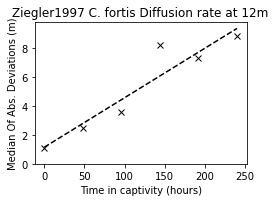

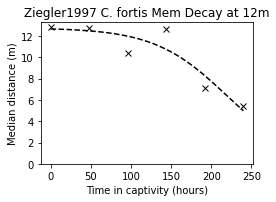

In [45]:
# Plot data from [11] Ziegler, P. E. and Wehner, R. Time-courses of memory decay in vector-based and landmark-based systems of navigation in desert ants, Cataglyphis fortis. 1997.
# Plots the Median homing distance and the Median Of Abs Deviations

# Data from paper
str_Ziegler1997 = 'Ziegler et al. (1997)'
Z_DaysInCaptivity = np.array([0, 2, 4, 6, 8, 10])
Z_HoursInCaptivity = Z_DaysInCaptivity * 24
Z_Homing_Distance_Median_12m=np.array([12.9, 12.8, 10.4, 12.7, 7.1, 5.4])
Z_Homing_Distance_MAD_12m=np.array([1.6, 2.2, 3.7, 8.1, 5.6, 4.0])
Z_Homing_Distance_MedianOfAbsDeviationsFirstTurnFromNestPos_12m=np.array([1.1, 2.5, 3.6, 8.2, 7.3, 8.8])

# Functions to use for regression to data
def func_linear(x, a, b):
    """ Linear function """
    y = a * x + b
    return y

def func_slowthenfastdecay(x, a, b):
    """ Decaying anti-exponential function """
    y = a - exp(x / b)
    return y

# Functions to use for regression to data
def func_parabola(x, a, b, c):
    """ Linear function """
    y = a * x**2 + b * x + c
    return y

def func_sigmoid_logistic_modified(x, a, x0, k):
    """ 
        Parameters:
            x0 : the centre of the function along the x axis
            k  : the slope of the logistic function
            a  : the maximum value
    """
    #return a * (1 - 1 / (1 + np.exp(-k * (x - x0))))
    return a / (1 + np.exp(k * (x - x0)))


# Select function to fit:
# -----------------------------------------------
# Function to fit 1
fit_func_name = 'func_slowthenfastdecay'
# Function to fit 2
#fit_func_name = 'func_parabola'
# Function to fit 3
fit_func_name = 'func_sigmoid_logistic_modified'
# -----------------------------------------------

if fit_func_name == 'func_slowthenfastdecay':
    fit_func = func_slowthenfastdecay
    fit_func_str = 'y = a - exp(x / b), [a, b] = {}'
if fit_func_name == 'func_parabola':
    fit_func = func_parabola
    fit_func_str = 'y = ax^2 + bx + c, [a, b, c] = {}'
if fit_func_name == 'func_sigmoid_logistic_modified':
    fit_func = func_sigmoid_logistic_modified
    fit_func_str = 'y = a / (1 + np.exp(k * (x - x0))), [a, x0, k] = {}'


# Plot data points
fig = plt.figure(figsize=figsize)
plt.plot(Z_HoursInCaptivity, Z_Homing_Distance_MedianOfAbsDeviationsFirstTurnFromNestPos_12m, 'xk')

# Fit a curve: Line to the Z_Homing_Distance_MedianOfAbsDeviationsFirstTurnFromNestPos_12m
params0 = [1, 0] # Initial guess of parameter values to optimize [a, b]
# Calculate fitted curve to data points
x_prime, y_prime, params, r2 = regress(Z_HoursInCaptivity, Z_Homing_Distance_MedianOfAbsDeviationsFirstTurnFromNestPos_12m, func_linear, params0, func_str = 'y = a * x + b, [a, b] = {}', x_range_min=None, x_range_max=None)
print('a = {:.3f}m/hour'.format(params[0]))

plt.plot(x_prime, y_prime, '--k')
plt.ylabel('Median Of Abs. Deviations (m)')
plt.xlabel('Time in captivity (hours)')
plt.ylim([0, None])
if not SAVE_PLOT:
    plt.title('Ziegler1997 C. fortis Diffusion rate at 12m')
if SAVE_PLOT:
    fig.savefig(os.path.join(figs_path, 'Ziegler_etal_1997_cataglyphis_fortis_12m_' + 'MedianOfAbsDeviations' + figs_extension), bbox_inches='tight', dpi=300)

fig = plt.figure(figsize=figsize)
# Plot data points: Median homing distance
plt.plot(Z_HoursInCaptivity, Z_Homing_Distance_Median_12m, 'xk')

# Fit a curve: Decaying anti-exponential function to the Homing_Distance_Median
if fit_func_name == 'func_slowthenfastdecay':
    params0 = [10, 10] # Initial guess of parameter values to optimize [a, b]
if fit_func_name == 'func_parabola':
    params0 = [10, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
if fit_func_name == 'func_sigmoid_logistic_modified':
    params0 = [12, 200, 1] # Initial guess of parameter values to optimize [a, x0, k]

x_prime, y_prime, params, r2 = regress(Z_HoursInCaptivity, Z_Homing_Distance_Median_12m, fit_func, params0, func_str = fit_func_str, x_range_min=Z_HoursInCaptivity[0], x_range_max=Z_HoursInCaptivity[-1])
print('a = {:.3f}m/hour'.format(params[0]))
Z_Homing_Distance_Median_12m_params = params.copy()

plot(x_prime, y_prime, '--k')
plt.ylabel('Median distance (m)')
plt.xlabel('Time in captivity (hours)')
plt.ylim([0, None])

if not SAVE_PLOT:
    plt.title('Ziegler1997 C. fortis Mem Decay at 12m')
if SAVE_PLOT:
    fig.savefig(os.path.join(figs_path, 'Ziegler_etal_1997_cataglyphis_fortis_12m_' + 'Homing_Distance_Median_fit_' + fit_func_name + figs_extension), bbox_inches='tight', dpi=300)
plt.show
# Store variables for later
Z_x_prime_12m = x_prime
Z_y_prime_12m = y_prime

#plot(Z_HoursInCaptivity, Z_Homing_Distance_MAD_12m, '.-', label='MAD')


Optimal parameters
y = a / (1 + np.exp(k * (x - x0))), [a, x0, k] = [1.17441627e+01 1.15961086e+02 4.00000000e-02]
R^2 = 0.7502903340387249
a = 11.744m/hour


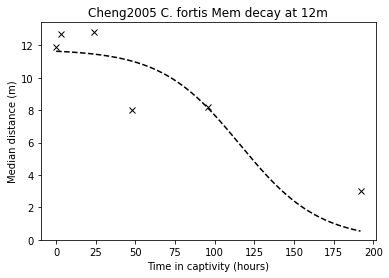

Optimal parameters
y = a / (1 + np.exp(k * (x - x0))), [a, x0, k] = [7.02651026e+00 1.50000000e+02 5.00000000e-02]
R^2 = 0.865858466489149
a = 7.027m/hour


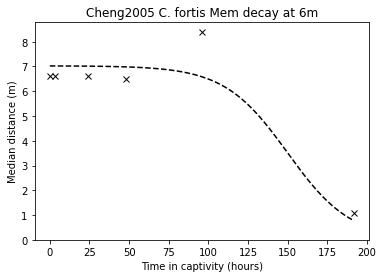

In [47]:
# Plot data from [1] Cheng, Ken, Narendra, Ajay, Wehner, Rüdiger, Behavioral ecology of odometric memories in desert ants: Acquisition, retention, and integration, 2005.
# Plots the Median homing distance (this paper has no Median Of Abs Deviations)

#plt.rcParams.update({'font.size': 14}) # Change the font size

# Data from paper
str_Cheng2005 = 'Cheng et al. (2005)'
C_HoursInCaptivity = np.array([0, 3, 24, 48, 96, 192])
C_Homing_Distance_Median_12m=np.array([11.9, 12.7, 12.8, 8.0, 8.2, 3.0])
C_Homing_Distance_CV_12m=np.array([0.21, 0.26, 0.34, 0.54, 0.64, 0.89])
C_Homing_Distance_Median_6m=np.array([6.6, 6.6, 6.6, 6.5, 8.4, 1.1])
C_Homing_Distance_CV_6m=np.array([0.38, 0.28, 0.62, 0.55, 0.64, 1.41])

# Plot data points: Median homing distance
fig = plt.figure()
plt.plot(C_HoursInCaptivity, C_Homing_Distance_Median_12m, 'xk', label='Median distance')

# Fit a curve: Decaying anti-exponential function to the C_Homing_Distance_Median_12m
bounds = [-inf, inf]
if fit_func_name == 'func_slowthenfastdecay':
    params0 = [10, 10] # Initial guess of parameter values to optimize [a, b]
if fit_func_name == 'func_parabola':
    params0 = [10, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
if fit_func_name == 'func_sigmoid_logistic_modified':
    params0 = [12, 100, 0.1] # Initial guess of parameter values to optimize [a, x0, k]
    bounds = [[0, 50, 0.04], [20, 150, 0.1]]
    
x_prime, y_prime, params, r2 = regress(C_HoursInCaptivity, C_Homing_Distance_Median_12m, fit_func, params0, func_str = fit_func_str, bounds = bounds, x_range_min=C_HoursInCaptivity[0], x_range_max=C_HoursInCaptivity[-1])
print('a = {:.3f}m/hour'.format(params[0]))
C_Homing_Distance_Median_12m_params = params.copy()
plt.plot(x_prime, y_prime, '--k', label='Median distance Fit')

plt.ylabel('Median distance (m)')
plt.xlabel('Time in captivity (hours)')
plt.ylim([0, None])
if not SAVE_PLOT:
    plt.title('Cheng2005 C. fortis Mem decay at 12m')
if SAVE_PLOT:
    fig.savefig(os.path.join(figs_path, 'Cheng_etal_2005_cataglyphis_fortis_12m_' + 'Homing_Distance_Median_fit_' + fit_func_name + figs_extension), bbox_inches='tight', dpi=300)
plt.show()
# Store variables for later
C_x_prime_12m = x_prime
C_y_prime_12m = y_prime

# plot(C_HoursInCaptivity, Homing_Distance_MAD_12m, '.-', label='CV')


# Plot data points: Median homing distance
fig = plt.figure()
plt.plot(C_HoursInCaptivity, C_Homing_Distance_Median_6m, 'xk', label='Median distance')

# Fit a curve: Decaying anti-exponential function to the C_Homing_Distance_Median_6m
bounds = (-inf, inf)
if fit_func_name == 'func_slowthenfastdecay':
    params0 = [10, 10] # Initial guess of parameter values to optimize [a, b]
if fit_func_name == 'func_parabola':
    params0 = [10, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
if fit_func_name == 'func_sigmoid_logistic_modified':
    params0 = [6, 100, 0.01] # Initial guess of parameter values to optimize [a, x0, k]
    bounds = [[0, 50, 0.01], [20, 150, 0.05]]

x_prime, y_prime, params, r2 = regress(C_HoursInCaptivity, C_Homing_Distance_Median_6m, fit_func, params0, func_str = fit_func_str, bounds = bounds, x_range_min=C_HoursInCaptivity[0], x_range_max=C_HoursInCaptivity[-1])
print('a = {:.3f}m/hour'.format(params[0]))
C_Homing_Distance_Median_6m_params = params.copy()
plt.plot(x_prime, y_prime, '--k', label='Median distance Fit')
plt.ylabel('Median distance (m)')
plt.xlabel('Time in captivity (hours)')
plt.ylim([0, None])

if not SAVE_PLOT:
    plt.title('Cheng2005 C. fortis Mem decay at 6m')
if SAVE_PLOT:
    plt.savefig('Data/Plots/' + 'Cheng_etal_2005_cataglyphis_fortis_6m_' + 'Homing_Distance_Median_fit_' + fit_func_name + '.png', bbox_inches='tight', dpi=300)
    plt.savefig('Data/Plots/' + 'Cheng_etal_2005_cataglyphis_fortis_6m_' + 'Homing_Distance_Median_fit_' + fit_func_name + '.pdf', bbox_inches='tight', dpi=300)
# Store variables for later
C_x_prime_6m = x_prime
C_y_prime_6m = y_prime


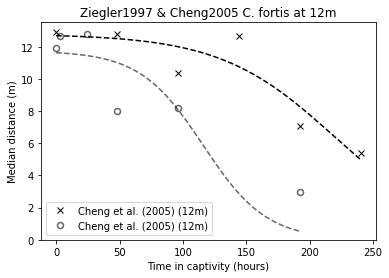

In [48]:
# Plots again the Median homing distance for both papers in one plot

fig = plt.figure()

# Plot data points
plt.plot(Z_HoursInCaptivity, Z_Homing_Distance_Median_12m, 'xk', alpha=1.00, label=str_Cheng2005 + ' (12m)')
plt.plot(C_HoursInCaptivity, C_Homing_Distance_Median_12m, 'ok', alpha=0.60, fillstyle='none', markeredgewidth=1.5, label=str_Cheng2005 + ' (12m)')

# Plot the fitted curves
plt.plot(Z_x_prime_12m, Z_y_prime_12m, '--k', alpha=1.00)
plt.plot(C_x_prime_12m, C_y_prime_12m, '--k', alpha=0.60)
plt.ylabel('Median distance (m)')
plt.xlabel('Time in captivity (hours)')
plt.ylim([0, None])
plt.legend()

if not SAVE_PLOT:
    plt.title('Ziegler1997 & Cheng2005 C. fortis at 12m')
if SAVE_PLOT:
    fig.savefig(os.path.join(figs_path, 'Ziegler_etal_1997_Cheng_etal_2005_cataglyphis_fortis_12m_' + 'Homing_Distance_Median_fit_' + fit_func_name + figs_extension), bbox_inches='tight', dpi=300)


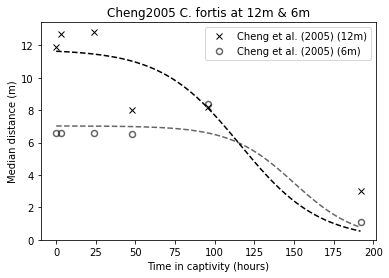

In [49]:
# Plots again the Median homing distance for both papers in one plot

fig = plt.figure()

# Plot data points
plt.plot(C_HoursInCaptivity, C_Homing_Distance_Median_12m, 'xk', alpha=1.00, label=str_Cheng2005 + ' (12m)')
plt.plot(C_HoursInCaptivity, C_Homing_Distance_Median_6m, 'ok', alpha=0.60, fillstyle='none', markeredgewidth=1.5, label=str_Cheng2005 + ' (6m)')

# Fit a fitted curves
plt.plot(C_x_prime_12m, C_y_prime_12m, '--k', alpha=1.00)
plt.plot(C_x_prime_6m, C_y_prime_6m, '--k', alpha=0.60)
plt.ylabel('Median distance (m)')
plt.xlabel('Time in captivity (hours)')
plt.ylim([0, None])
plt.legend()

if not SAVE_PLOT:
    plt.title('Cheng2005 C. fortis at 12m & 6m')
if SAVE_PLOT:
    fig.savefig(os.path.join(figs_path, 'Cheng_etal_2005_cataglyphis_fortis_12m_6m_' + 'Homing_Distance_Median_fit_' + fit_func_name + figs_extension), bbox_inches='tight', dpi=300)
    

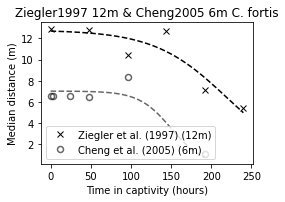

In [50]:
# Plots again the Median homing distance for both papers in one plot

fig = plt.figure(figsize=figsize)

# Plot data points
plt.plot(Z_HoursInCaptivity, Z_Homing_Distance_Median_12m, 'xk', alpha=1.00, label=str_Ziegler1997 + ' (12m)')
plt.plot(C_HoursInCaptivity, C_Homing_Distance_Median_6m, 'ok', alpha=0.60, fillstyle='none', markeredgewidth=1.5, label=str_Cheng2005 + ' (6m)')

# Fit a fitted curves
plt.plot(Z_x_prime_12m, Z_y_prime_12m, '--k', alpha=1.00)
plt.plot(C_x_prime_6m, C_y_prime_6m, '--k', alpha=0.60)
plt.ylabel('Median distance (m)')
plt.xlabel('Time in captivity (hours)')
plt.legend()

if not SAVE_PLOT:
    plt.title('Ziegler1997 12m & Cheng2005 6m C. fortis')
if SAVE_PLOT:
    fig.savefig(os.path.join(figs_path, 'Ziegler_etal_1997_12m_Cheng_etal_2005_6m_cataglyphis_fortis_' + 'Homing_Distance_Median_fit_' + fit_func_name + figs_extension), bbox_inches='tight', dpi=300)
    

### Systematic weight bias

In [69]:
input_path = '/Volumes/WD Elements 25A3 Media/Documents/Research/PhD/Projects/Recurrent_Net_Memory/Attractor_Based_Memory_Plaussibility_Study/'
input_file = 'collected-wrapped-NMDA-SHIFT.npy' # This is the non unwrapped recordings

input_filename = os.path.join(input_path, input_file)

if os.path.exists(input_filename):
    # Save all data in the file
    data = np.load(input_filename, allow_pickle=True, encoding='bytes')
else: 
    print('ERROR: File does not exist: {:s}'.format(input_filename))

In [70]:
# The above loaded data from the file to the variable data has the following structure:
#     data[()][model][poisson_neuron_noise][neurons_num].keys()    (option 1)
#     data.item()[model][poisson_neuron_noise][neurons_num].keys() (option 2)
#          model = ['NMDA', 'EC_LV_1'][0]
#          poisson_neuron_noise = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009][0]
#          neurons_num = [128, 256, 512, 1024, 2048, 4096, 8192][0]
#  eg data.item()['NMDA'][0.001][1024]['theta_ts_list'] = time_series_collection
# The way to access and explore the dict entries in the the variable data is
#     data[()].keys()
#     or
#     data.item().keys()
model = ['NMDA-SHIFT-0.001', 'NMDA-SHIFT-0.0005', 'NMDA-SHIFT-0.0001', 'NMDA-SHIFT-0.00001'][1]
poisson_neuron_noise = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009][4]
neurons_num = [128, 256, 512, 1024, 2048, 4096, 8192][1]
tau = ['complex', '10m', '50m', '100m', '500m', '1000m', '5000m', '10000m', '50000m'][0]
data.item()[model][poisson_neuron_noise][tau][neurons_num].keys()

dict_keys(['theta_ts_list', 'theta_ts_abs_diff_mean', 'theta_ts_abs_diff_std', 't_snapshots', 'stimulus_center_deg', 'N_excitatory', 'idx_monitored_neurons_excit'])

TypeError: 'NoneType' object is not subscriptable

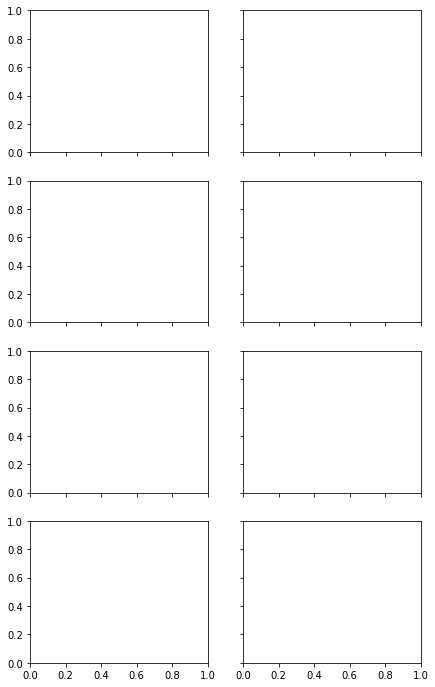

In [57]:
# Plot experimental conditions collated in combined plots
# Noise = 0.005 seems to be a nice choise
# The jump at the EC_LV_1 with N=128 corresponds to 0.622 neurons, so it is a jump to the middle in average

# Choose what to plot
plot_types = ['theta', 'abs_diff_mean', 'abs_diff_std', 'theta_mean']
plot_type = plot_types[0]                       # Choose what to plot 
                                                #       'theta': theta_ts_list, (In this version there is not much point of using this option because it will plot all network sizes in the same plot)
                                                #       'abs_diff_mean': theta_ts_abs_diff_mean, 
                                                #       'abs_diff_std': theta_ts_abs_diff_std, 
                                                #       'theta_mean': calculates and plots the mean of theta_ts_list

#models = ['NMDA-SHIFT']  # List of the neuron models present in the collected recordings file
models = ['NMDA-SHIFT-0.001', 'NMDA-SHIFT-0.0005', 'NMDA-SHIFT-0.0001', 'NMDA-SHIFT-0.00001'] # List of the neuron models present in the collected recordings file
poisson_neuron_noises = [0.005] # List of the neuron noise present in the collected recordings file
neurons_nums = [256] # List of the network sizes present in the collected recordings file
taus = ['complex', '10ms', '50ms', '100ms', '500ms', '1000ms', '5000ms', '10000ms', '50000ms']

#model = models[0]                               # Choose which neuron model results to plot
#poisson_neuron_noise = poisson_neuron_noises[0] # Choose what neuron noise results to plot
#neurons_num = neurons_nums[0]                   # Choose which network size results to plot
tau = taus[0]

# Mapping of the time series into a custom range (from theta={0,360} to eg m={0,100})
plot_scale_mapping = [(0, 360), (0, 100)]
normalise_start = -50 + 12 # To start from 12[m]
plot_from_t = None

# Plot labeling
if plot_type == plot_types[0]: # Plot theta_ts_list
    plot_mapping_units = 'Bump location (m)'
if plot_type == plot_types[1]: # Plot abs_diff_mean
    plot_mapping_units = 'Mean Absolute Deviation (m)'
if plot_type == plot_types[2]: # Plot abs_diff_std
    plot_mapping_units = 'Mean Absolute Deviation SD? (m)'
if plot_type == plot_types[3]: # Plot the median of theta_ts_list
    plot_mapping_units = 'Median bump location (m)'

# Colour scheme for plots
colourscheme = 'viridis' # 'viridis' or 'none'

if colourscheme == 'viridis':
    viridis = plt.cm.get_cmap('viridis')
    
for poisson_neuron_noise in poisson_neuron_noises:
    if SAVE_PLOT:
        fig, axs = plt.subplots(nrows=len(models), ncols=2, figsize=(7, 12), sharex=True, sharey=True)
    else:
        fig, axs = plt.subplots(nrows=len(models), ncols=2, figsize=(7, 12), sharex=True, sharey=True)

    for indx_i, model in enumerate(models):
        for indx_j, neurons_num in enumerate(neurons_nums):
            # Get reference to the appropriate subplot
            ax = axs[indx_i, indx_j]
            # Get the list of theta recordings time series
            theta_ts_list = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_list']
            t_snapshots = data[()][model][poisson_neuron_noise][tau][neurons_num]['t_snapshots']
            theta_ts_abs_diff_mean = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_abs_diff_mean']
            theta_ts_abs_diff_std = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_abs_diff_std']
            
            if not SAVE_PLOT:
                fig.suptitle('Noise = ' + str(poisson_neuron_noise))
            
            # In this version there is not much point of using this option because it will plot all network sizes in the same plot
            if plot_type == plot_types[0]: # Plot theta_ts_list
                ts_list, t_snaps = preprocess_time_series(theta_ts_list, t_snapshots, scale=plot_scale_mapping, plot_from_t=None, normalise_start=None)
                for i, ts in enumerate(ts_list):
                    ax.plot(t_snaps/second, ts+normalise_start, color='black', alpha=0.2)
                    ax.set_title('NMDA SHIFT = ' + str(model))
                    ax.set_xlabel('Time (s)')
                    #ax.set_ylim((0, 360))
                    ax.set_ylabel(plot_mapping_units)

            if plot_type == plot_types[1]: # Plot theta_ts_abs_diff_mean
                ts_list, t_snaps = preprocess_time_series(theta_ts_abs_diff_mean, t_snapshots, scale=plot_scale_mapping, plot_from_t=None, normalise_start=None)
                if colourscheme == 'viridis': 
                    colour = viridis(indx_j/len(neurons_nums))
                    ax.plot(t_snaps/second, ts_list, label=str(neurons_num), color=colour)
                else: 
                    ax.plot(t_snaps/second, ts_list, label=str(neurons_num))
                #ax.set_title('NMDA SHIFT = ' + str(model))
                ax.set_xlabel('Time (s)')
                ax.set_ylabel(plot_mapping_units)
                #ax.set_ylim((0, 360))
                ax.legend()

            if plot_type == plot_types[2]: # Plot theta_ts_abs_diff_std
                ts_list, t_snaps = preprocess_time_series(theta_ts_abs_diff_std, t_snapshots, scale=plot_scale_mapping, plot_from_t=None, normalise_start=None)
                if colourscheme == 'viridis': 
                    colour = viridis(indx_j/len(neurons_nums))
                    ax.plot(t_snaps/second, ts_list, label=str(neurons_num), color=colour)
                else:
                    ax.plot(t_snaps/second, ts_list, label=str(neurons_num))
                #ax.set_title('NMDA SHIFT = ' + str(model))
                ax.set_xlabel('Time (s)')
                ax.set_ylabel(plot_mapping_units)
                #ax.set_ylim((0, 360))
                ax.legend()
            
            if plot_type == plot_types[3]: # Plot theta_mean
                ts_list, t_snaps = preprocess_time_series(theta_ts_list, t_snapshots, scale=plot_scale_mapping, plot_from_t=None, normalise_start=None)
                ax.plot(t_snapshots, np.median(np.array(ts_list)+normalise_start, axis=0))
                ax.set_title('NMDA SHIFT = ' + str(model))
                ax.set_xlabel('Time (s)')
                #ax.set_ylim((0, 360))
                ax.set_ylabel(plot_mapping_units)

            #if indx_i == 1:
            #    ax.set_ylim([0, 0.04])
    fig.tight_layout()
    SAVE_PLOT = True
    if SAVE_PLOT:
        fig.savefig(os.path.join(figs_path, 'pub_effect_of_systematic_weight_anisotropy_on_bump_shift_' + plot_type + '_range100m' + '_noise' + str(poisson_neuron_noise) + '_neurons' + str(neurons_num) + figs_extension), bbox_inches='tight', dpi=300)


Noise = 0.005
N = 256
Model and skewed Gaussian shift factor = NMDA-SHIFT-0.0005
ts_list len =  249


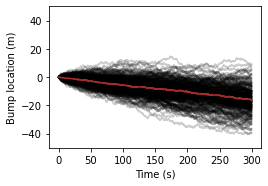

In [71]:
# Choose what to plot
plot_types = ['theta', 'abs_diff_mean', 'abs_diff_std', 'theta_mean']
plot_type = plot_types[0]                       # Choose what to plot 
                                                #       'theta': theta_ts_list, (In this version there is not much point of using this option because it will plot all network sizes in the same plot)
                                                #       'abs_diff_mean': theta_ts_abs_diff_mean, 
                                                #       'abs_diff_std': theta_ts_abs_diff_std, 
                                                #       'theta_mean': calculates and plots the mean of theta_ts_list

models = ['NMDA-SHIFT-0.001', 'NMDA-SHIFT-0.0005', 'NMDA-SHIFT-0.0001', 'NMDA-SHIFT-0.00001'] # List of the neuron models present in the collected recordings file
poisson_neuron_noises = [0.005] # List of the neuron noise present in the collected recordings file
neurons_nums = [256] # List of the network sizes present in the collected recordings file
taus = ['complex', '10ms', '50ms', '100ms', '500ms', '1000ms', '5000ms', '10000ms', '50000ms']

model = models[1]                               # Choose which neuron model results to plot
poisson_neuron_noise = poisson_neuron_noises[0] # Choose what neuron noise results to plot
neurons_num = neurons_nums[0]                   # Choose which network size results to plot
tau = taus[0]
plot_traces_subset = 249 # Plot the first 249 traces to have the same sample as the without shift model

# Mapping of the time series into a custom range (from theta={0,360} to eg m={0,100})
plot_scale_mapping = [(0, 360), (0, 100)]
normalise_start = -50 + 12 # To start from 12[m]
plot_from_t = None

print('Noise = ' + str(poisson_neuron_noise))
print('N = ' + str(neurons_num))
print('Model and skewed Gaussian shift factor = ' + model)
data_dic = data[()][model][poisson_neuron_noise][tau][neurons_num]
plot_type = ['theta', 'abs_diff_mean', 'abs_diff_std'][0]
fig = plt.figure(figsize=figsize)
ax = plt.gca()
plot_individual_traces(ax, data_dic, scale=plot_scale_mapping, plot_type=plot_type, y_bias=-50, ylabel = 'Bump location (m)', plot_traces_subset=plot_traces_subset, colour='black', plot_median=True, colour_median='brown', SAVE_PLOT=SAVE_PLOT)
#ax.set_ylim([0, 100])
ax.set_ylim([-50, 50])

if SAVE_PLOT:
    fig.savefig(os.path.join(figs_path, 'pub_' + model + '_effect_of_systematic_weight_anisotropy_on_bump_shift_' + plot_type + '_range100m' + '_neurons' + str(neurons_num) + '_noise' + str(poisson_neuron_noise) + figs_extension), bbox_inches='tight', dpi=300)


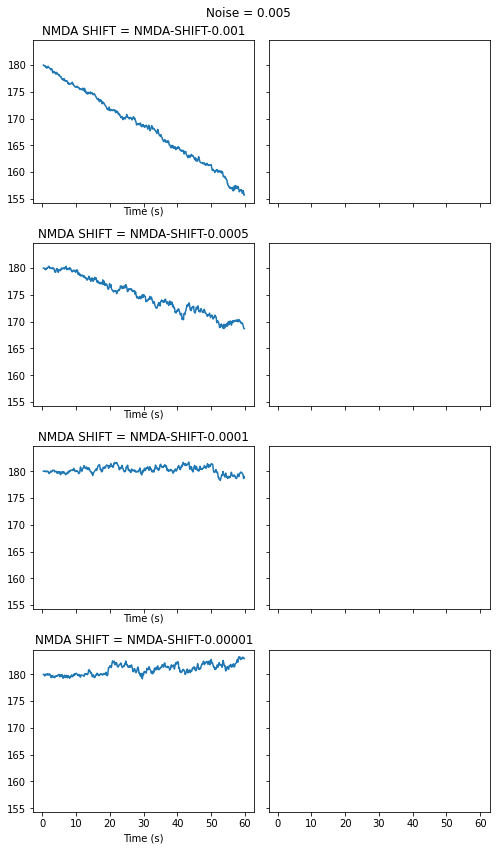

In [39]:
# Plot each experimental condition in separate plot

# Choose what to plot
plot_types = ['theta', 'abs_diff_mean', 'abs_diff_std', 'theta_mean']
plot_type = plot_types[3]                       # Choose what to plot 
                                                #       'theta': theta_ts_list, 
                                                #       'abs_diff_mean': theta_ts_abs_diff_mean, 
                                                #       'abs_diff_std': theta_ts_abs_diff_std
                                                #       'theta_mean': calculates and plots the mean of theta_ts_list

models = ['NMDA-SHIFT-0.001', 'NMDA-SHIFT-0.0005', 'NMDA-SHIFT-0.0001', 'NMDA-SHIFT-0.00001'] # List of the neuron models present in the collected recordings file
poisson_neuron_noises = [0.005] # List of the neuron noise present in the collected recordings file
neurons_nums = [256] # List of the network sizes present in the collected recordings file
taus = ['complex', '10ms', '50ms', '100ms', '500ms', '1000ms', '5000ms', '10000ms', '50000ms']

#model = models[0]                               # Choose which neuron model results to plot
#poisson_neuron_noise = poisson_neuron_noises[0] # Choose what neuron noise results to plot
#neurons_num = neurons_nums[0]                   # Choose which network size results to plot
tau = taus[0]

for poisson_neuron_noise in poisson_neuron_noises:
    fig, axs = plt.subplots(nrows=len(models), ncols=2, figsize=(7, 12), sharex=True, sharey=True)

    for indx_i, model in enumerate(models):
        for indx_j, neurons_num in enumerate(neurons_nums):
            # Get reference to the appropriate subplot
            ax = axs[indx_i, indx_j]
            # Get the list of theta recordings time series
            theta_ts_list = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_list']
            t_snapshots = data[()][model][poisson_neuron_noise][tau][neurons_num]['t_snapshots']
            theta_ts_abs_diff_mean = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_abs_diff_mean']
            theta_ts_abs_diff_std = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_abs_diff_std']

            fig.suptitle('Noise = ' + str(poisson_neuron_noise))

            if plot_type == plot_types[0]: # Plot theta_ts_list
                for i, ts in enumerate(theta_ts_list):
                    ax.plot(t_snapshots, ts)
                    ax.set_title('NMDA SHIFT = ' + str(model))
                    ax.set_xlabel('Time (s)')
                    #ax.set_ylim((0, 360))

            if plot_type == plot_types[1]: # Plot theta_ts_abs_diff_mean
                ax.plot(t_snapshots, theta_ts_abs_diff_mean)
                ax.set_title('NMDA SHIFT = ' + str(model))
                ax.set_xlabel('Time (s)')
                #ax.set_ylim((0, 360))

            if plot_type == plot_types[2]: # Plot theta_ts_abs_diff_std
                ax.plot(t_snapshots, theta_ts_abs_diff_std)
                ax.set_title('NMDA SHIFT = ' + str(model))
                ax.set_xlabel('Time (s)')
                #ax.set_ylim((0, 360))

            if plot_type == plot_types[3]: # Plot theta_mean
                ax.plot(t_snapshots, np.median(np.array(theta_ts_list), axis=0))
                ax.set_title('NMDA SHIFT = ' + str(model))
                ax.set_xlabel('Time (s)')
                #ax.set_ylim((0, 360))
    
    fig.tight_layout()

Noise = 0.005
N = 256
Model and skewd Gaussian shift factor = NMDA-SHIFT-0.0005


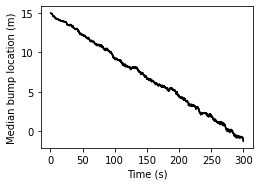

In [61]:
# Plot each experimental condition in separate plot

# Choose what to plot
plot_types = ['theta', 'abs_diff_mean', 'abs_diff_std', 'theta_mean']
plot_type = plot_types[3]                       # Choose what to plot 
                                                #       'theta': theta_ts_list, 
                                                #       'abs_diff_mean': theta_ts_abs_diff_mean, 
                                                #       'abs_diff_std': theta_ts_abs_diff_std
                                                #       'theta_mean': calculates and plots the mean of theta_ts_list

models = ['NMDA-SHIFT-0.001', 'NMDA-SHIFT-0.0005', 'NMDA-SHIFT-0.0001', 'NMDA-SHIFT-0.00001'] # List of the neuron models present in the collected recordings file
poisson_neuron_noises = [0.005] # List of the neuron noise present in the collected recordings file
neurons_nums = [256] # List of the network sizes present in the collected recordings file
taus = ['complex', '10ms', '50ms', '100ms', '500ms', '1000ms', '5000ms', '10000ms', '50000ms']

model = models[1]                               # Choose which neuron model results to plot
poisson_neuron_noise = poisson_neuron_noises[0] # Choose what neuron noise results to plot
neurons_num = neurons_nums[0]                   # Choose which network size results to plot
tau = taus[0]

print('Noise = ' + str(poisson_neuron_noise))
print('N = ' + str(neurons_num))
print('Model and skewd Gaussian shift factor = ' + model)
data_dic = data[()][model][poisson_neuron_noise][tau][neurons_num]

fig = plt.figure(figsize=figsize)
ax = plt.gca()

# Get the list of theta recordings time series
theta_ts_list = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_list']
t_snapshots = data[()][model][poisson_neuron_noise][tau][neurons_num]['t_snapshots']
theta_ts_abs_diff_mean = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_abs_diff_mean']
theta_ts_abs_diff_std = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_abs_diff_std']
ts_list, t_snaps = preprocess_time_series(theta_ts_list, t_snapshots, scale=plot_scale_mapping, plot_from_t=None, normalise_start=None)

if plot_type == plot_types[3]: # Plot theta_mean
    ax.plot(t_snaps, np.median(np.array(ts_list), axis=0)-50+15, color='black')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Median bump location (m)')
    #ax.set_ylim((0, 360))

if SAVE_PLOT:
    fig.savefig(os.path.join(figs_path, 'pub_' + model + '_effect_of_systematic_weight_anisotropy_on_bump_shift_' + plot_type + '_range100m' + '_neurons' + str(neurons_num) + '_noise' + str(poisson_neuron_noise) + figs_extension), bbox_inches='tight', dpi=300)
    

### Effect of neuronal time constant on bump stability 

In [74]:
input_path = '/Volumes/WD Elements 25A3 Media/Documents/Research/PhD/Projects/Recurrent_Net_Memory/Attractor_Based_Memory_Plaussibility_Study/'
input_file = 'collected-wrapped.npy' # This is the non unwrapped recordings
#input_file = 'collected-wrapped-NMDA-EC_LV_1-bak27082021.npy' # This is the non unwrapped recordings
input_file = 'collected-wrapped-SIMPLE.npy' # This is the non unwrapped recordings with various tau values
#input_file = 'collected-unwrapped-SIMPLE-bak01092021-2.npy'
input_file = 'collected-unwrapped-SIMPLE.npy' # This is the unwrapped recordings with various tau values
input_file = 'collected-wrapped-SIMPLE-TAU2.npy' # This is the non unwrapped recordings with various tau values
input_file = 'collected-unwrapped-SIMPLE-TAU2.npy' # This is the unwrapped recordings with various tau values
input_file = 'collected-unwrapped-NMDA-TAU.npy' # This is the unwrapped recordings with various tau values

input_filename = os.path.join(input_path, input_file)

if os.path.exists(input_filename):
    # Save all data in the file
    data = np.load(input_filename, allow_pickle=True, encoding='bytes')
else: 
    print('ERROR: File does not exist: {:s}'.format(input_filename))

In [75]:
# The above loaded data from the file to the variable data has the following structure:
#     data[()][model][poisson_neuron_noise][neurons_num].keys()    (option 1)
#     data.item()[model][poisson_neuron_noise][neurons_num].keys() (option 2)
#          model = ['NMDA', 'EC_LV_1'][0]
#          poisson_neuron_noise = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009][0]
#          neurons_num = [128, 256, 512, 1024, 2048, 4096, 8192][0]
#  eg data.item()['NMDA'][0.001][1024]['theta_ts_list'] = time_series_collection
# The way to access and explore the dict entries in the the variable data is
#     data[()].keys()
#     or
#     data.item().keys()
model = ['NMDA', 'EC_LV_1', 'SIMPLE'][2]
poisson_neuron_noise = [0.0001, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.010, 0.100][5]
model = ['NMDA', 'EC_LV_1', 'SIMPLE', 'SIMPLE-TAU2', 'NMDA-TAU'][4]
poisson_neuron_noise = [0.0001, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.010, 0.100, 1.0, 1.4][13]
neurons_num = [128, 256, 512, 1024, 2048, 4096, 8192][1]
tau = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms', '500ms', '1000ms', '5000ms', '10000ms', '50000ms', '100000ms'][4]
#data.item()[model][poisson_neuron_noise][tau][neurons_num].keys()
data.item()[model][poisson_neuron_noise][tau][neurons_num].keys()

dict_keys(['theta_ts_list', 'theta_ts_abs_diff_mean', 'theta_ts_abs_diff_std', 't_snapshots', 'stimulus_center_deg', 'N_excitatory', 'idx_monitored_neurons_excit'])

Trials tau=0.5ms n=398
Trials tau=1ms n=336
Trials tau=5ms n=299
Trials tau=10ms n=380
Trials tau=20ms n=368
Trials tau=30ms n=407
Trials tau=40ms n=420
Trials tau=50ms n=386
Trials tau=60ms n=365
Trials tau=70ms n=373
Trials tau=80ms n=212
Trials tau=90ms n=250
Trials tau=100ms n=291


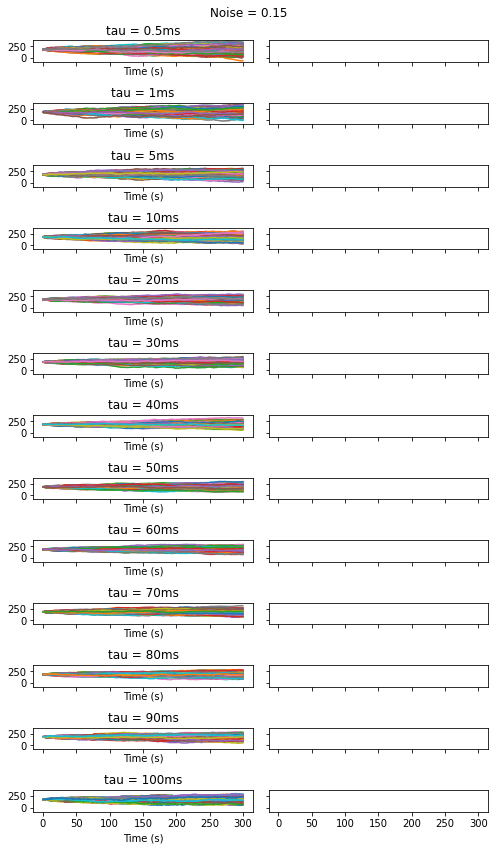

In [76]:
# Plot each experimental condition in separate plot
#noise=0.002 Dispersion seems to be decreasing with tau value for tau 10-1000 not for 10000
#noise=0.005 There does not seem to be difference between tau values
#noise=0.008 Very noisy. Dispersion maybe decreases with tau value but it is very noisy

# Choose what to plot
plot_types = ['theta', 'abs_diff_mean', 'abs_diff_std']
plot_type = plot_types[0]                       # Choose what to plot 
                                                #       'theta': theta_ts_list, 
                                                #       'abs_diff_mean': theta_ts_abs_diff_mean, 
                                                #       'abs_diff_std': theta_ts_abs_diff_std

show_option = 1 # Plot with poisson_neuron_noise=1.4 and neurons_nums=256
show_option = 2 # Plot with poisson_neuron_noise=0.3 and neurons_nums=256
show_option = 3 # Plot with poisson_neuron_noise=0.15 and neurons_nums=512
#show_option = 4 # Plot with poisson_neuron_noise=0.05 and neurons_nums=512
            
models = ['SIMPLE']  # List of the neuron models present in the collected recordings file
models = ['SIMPLE-TAU2']
models = ['NMDA-TAU']
poisson_neuron_noises = [0.002] # List of the neuron noise present in the collected recordings file
poisson_neuron_noises = [0.0, 0.0001, 0.001, 0.005, 0.010, 0.100] # List of the neuron noise present in the collected recordings file
poisson_neuron_noises = [1.0]

if show_option == 1:
    neurons_nums = [256] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [1.4]
    taus = ['complex', '1ms', '10ms', '50ms', '100ms', '500ms', '1000ms', '5000ms', '10000ms', '50000ms', '100000ms'][1:]
    taus = ['complex', '1ms', '10ms', '100ms', '1000ms', '10000ms', '100000ms'][2:7]
    taus = ['complex', '1ms', '10ms', '100ms', '1000ms', '10000ms', '100000ms'][1:4]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '50ms', '100ms', '1000ms', '10000ms', '100000ms'][1:7]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms', '1000ms', '10000ms', '100000ms'][1:14]
    # temp
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '50ms', '80ms', '100ms', '1000ms', '10000ms', '100000ms'][1:10]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '70ms', '80ms', '90ms', '100ms', '1000ms', '10000ms', '100000ms'][1:12]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms', '1000ms', '10000ms', '100000ms'][1:14]

# Newly collected data with 256 neurons
if show_option == 2:
    neurons_nums = [256] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.3]
    taus = ['complex', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms'][1:]

# Newly collected data with 512 neurons
if show_option == 3:
    neurons_nums = [512] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.15]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms'][1:]

if show_option == 4:
    neurons_nums = [512] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.05]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms'][1:]


#model = models[0]                               # Choose which neuron model results to plot
#poisson_neuron_noise = poisson_neuron_noises[0] # Choose what neuron noise results to plot
neurons_num = neurons_nums[0]                   # Choose which network size results to plot


for poisson_neuron_noise in poisson_neuron_noises:
    fig, axs = plt.subplots(nrows=len(taus), ncols=2, figsize=(7, 12), sharex=True, sharey=True)
    
    for indx_i, model in enumerate(models):
        for indx_j, tau in enumerate(taus):
            # Get reference to the appropriate subplot
            ax = axs[indx_j, indx_i]
            try: 
                # Get the list of theta recordings time series
                theta_ts_list = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_list']
                t_snapshots = data[()][model][poisson_neuron_noise][tau][neurons_num]['t_snapshots']
                theta_ts_abs_diff_mean = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_abs_diff_mean']
                theta_ts_abs_diff_std = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_abs_diff_std']

                fig.suptitle('Noise = ' + str(poisson_neuron_noise))

                if plot_type == plot_types[0]: # Plot theta_ts_list
                    print('Trials tau={:} n={:}'.format(tau, len(theta_ts_list)))
                    #theta_ts_list = theta_ts_list[:134]
                    for i, ts in enumerate(theta_ts_list):
                        ax.plot(t_snapshots, ts)
                        ax.set_title('tau = ' + str(tau))
                        ax.set_xlabel('Time (s)')
                        #ax.set_ylim((0, 360))

                if plot_type == plot_types[1]: # Plot theta_ts_abs_diff_mean
                    ax.plot(t_snapshots, theta_ts_abs_diff_mean)
                    ax.set_title('tau = ' + str(tau))
                    ax.set_xlabel('Time (s)')
                    #ax.set_ylim((0, 360))

                if plot_type == plot_types[2]: # Plot theta_ts_abs_diff_std
                    ax.plot(t_snapshots, theta_ts_abs_diff_std)
                    ax.set_title('tau = ' + str(tau))
                    ax.set_xlabel('Time (s)')
                    #ax.set_ylim((0, 360))
            except:
                pass

    fig.tight_layout()

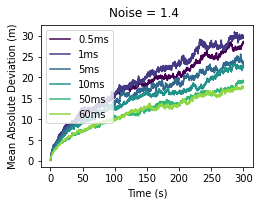

In [122]:
# Plot experimental conditions collated in combined plots
# Noise = 0.005 seems to be a nice choise
# The jump at the EC_LV_1 with N=128 corresponds to 0.622 neurons, so it is a jump to the middle in average

# Choose what to plot
plot_types = ['theta', 'abs_diff_mean', 'abs_diff_std']
plot_type = plot_types[1]                       # Choose what to plot 
                                                #       'theta': theta_ts_list, (In this version there is not much point of using this option because it will plot all network sizes in the same plot)
                                                #       'abs_diff_mean': theta_ts_abs_diff_mean, 
                                                #       'abs_diff_std': theta_ts_abs_diff_std

plot_option = 1 # Plot with poisson_neuron_noise=1.4 and neurons_nums=256
#plot_option = 2 # Plot with poisson_neuron_noise=0.3 and neurons_nums=256
#plot_option = 3 # Plot with poisson_neuron_noise=0.15 and neurons_nums=512
#plot_option = 4 # Plot with poisson_neuron_noise=0.05 and neurons_nums=512


models = ['SIMPLE']  # List of the neuron models present in the collected recordings file
models = ['SIMPLE-TAU2']
models = ['NMDA-TAU']
poisson_neuron_noises = [0.002] # List of the neuron noise present in the collected recordings file
poisson_neuron_noises = [0.0, 0.0001, 0.001, 0.005, 0.010, 0.100] # List of the neuron noise present in the collected recordings file
poisson_neuron_noises = [1.0]

if plot_option == 1:
    neurons_nums = [256] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [1.4]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms', '1000ms', '10000ms', '100000ms'][1:13]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '50ms', '60ms'][1:]

#taus = ['0.5ms', '1ms', '10ms', '40ms', '50ms', '80ms']

# Newly collected data with 256 neurons - These data look very bad worse than with possion_noise=1.4
if plot_option == 2:
    neurons_nums = [256] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.3]
    taus = ['complex', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms'][1:]
    taus = ['complex', '1ms', '10ms', '50ms'][1:]
    taus = ['complex', '1ms', '10ms', '20ms', '80ms'][1:]

# Newly collected data with 512 neurons - These data use more neurons for having less poisson_noise and 
# look as goood as the 256 neurons with poisson_noise=1.4
if plot_option == 3:
    neurons_nums = [512] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.15]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms'][1:]
    taus = ['complex', '1ms', '10ms', '50ms'][1:] # Above 20ms overlaps with 20ms and 100ms overlaps with 10ms. Above 80ms plots seem to be more noisy than with lower taus.
    taus = ['complex', '0.5ms', '1ms', '10ms', '30ms', '40ms'][1:] # Above 20ms overlaps with 20ms and 100ms overlaps with 10ms. Above 80ms plots seem to be more noisy than with lower taus.
    #taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '30ms', '40ms'][1:] # The 5ms sample has a funny drop in error after 250s probably an unwrapping issue
    # To try without unwrapping if 5ms shows up ok. It looks the same.
    
# Newly collected data with 512 neurons - These data use more neurons for having even less poisson_noise and 
# look as goood as the 256 neurons with poisson_noise=1.4
if plot_option == 4:
    neurons_nums = [512] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.05]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms'][1:]
    taus = ['complex', '1ms', '10ms', '40ms', '60ms'][1:] # Above 20ms overlaps with 20ms and 100ms overlaps with 10ms. Above 80ms plots seem to be more noisy than with lower taus.
    taus = ['complex', '0.5ms', '1ms', '10ms', '40ms', '60ms'][1:] # Above 20ms overlaps with 20ms and 100ms overlaps with 10ms. Above 80ms plots seem to be more noisy than with lower taus.
    # To collect and include 5ms trials

#model = models[0]                               # Choose which neuron model results to plot
#poisson_neuron_noise = poisson_neuron_noises[0] # Choose what neuron noise results to plot
neurons_num = neurons_nums[0]                   # Choose which network size results to plot


# Mapping of the time series into a custom range (from theta={0,360} to eg m={0,100})
plot_mapping_units = 'Mean Absolute Deviation (m)'
plot_scale_mapping = [(0, 360), (0, 100)]
normalise_start = None
plot_from_t = None

# Colour scheme for plots
colourscheme = 'viridis' # 'viridis' or 'none'

if colourscheme == 'viridis':
    viridis = plt.cm.get_cmap('viridis')
    #viridis = plt.cm.get_cmap('Greys')
    
for poisson_neuron_noise in poisson_neuron_noises:
    #if SAVE_PLOT:
    #    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 3), sharex=True, sharey=True)
    #else:
    #    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 3.5), sharex=True, sharey=True)
    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    
    for indx_i, model in enumerate(models):
        for indx_j, tau in enumerate(taus):
            # Get reference to the appropriate subplot
            #ax = axs[indx_i]
            # Get the list of theta recordings time series
            theta_ts_list = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_list']
            t_snapshots = data[()][model][poisson_neuron_noise][tau][neurons_num]['t_snapshots']
            theta_ts_abs_diff_mean = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_abs_diff_mean']
            theta_ts_abs_diff_std = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_abs_diff_std']
            
            if not SAVE_PLOT:
                fig.suptitle('Noise = ' + str(poisson_neuron_noise))
            
            # In this version there is not much point of using this option because it will plot all network sizes in the same plot
            if plot_type == plot_types[0]: # Plot theta_ts_list
                ts_list, t_snaps = preprocess_time_series(theta_ts_list, t_snapshots, scale=plot_scale_mapping, plot_from_t=None, normalise_start=None)
                for i, ts in enumerate(ts_list):
                    ax.plot(t_snaps/second, ts)
                    ax.set_title('$\tau$ = ' + str(tau))
                    ax.set_xlabel('Time (s)')
                    #ax.set_ylim((0, 360))
                    ax.set_ylabel(plot_mapping_units)

            if plot_type == plot_types[1]: # Plot theta_ts_abs_diff_mean
                ts_list, t_snaps = preprocess_time_series(theta_ts_abs_diff_mean, t_snapshots, scale=plot_scale_mapping, plot_from_t=None, normalise_start=None)
                if colourscheme == 'viridis': 
                    colour = viridis(indx_j/len(taus))
                    ax.plot(t_snaps/second, ts_list, label=tau, color=colour)
                else: 
                    ax.plot(t_snaps/second, ts_list, label=tau)
                #ax.set_title('N = ' + str(neurons_num))
                ax.set_xlabel('Time (s)')
                ax.set_ylabel(plot_mapping_units)
                #ax.set_ylim((0, 360))
                ax.legend()

            if plot_type == plot_types[2]: # Plot theta_ts_abs_diff_std
                ts_list, t_snaps = preprocess_time_series(theta_ts_abs_diff_std, t_snapshots, scale=plot_scale_mapping, plot_from_t=None, normalise_start=None)
                if colourscheme == 'viridis': 
                    colour = viridis(indx_j/len(taus))
                    ax.plot(t_snaps/second, ts_list, label=tau, color=colour)
                else:
                    ax.plot(t_snaps/second, ts_list, label=tau)
                #ax.set_title('N = ' + str(neurons_num))
                ax.set_xlabel('Time (s)')
                ax.set_ylabel(plot_mapping_units)
                #ax.set_ylim((0, 360))
                ax.legend()

    #fig.tight_layout()
    
    if SAVE_PLOT:
        fig.savefig(os.path.join(figs_path, 'pub_' + model + '_effect_of_tau_on_dispersion_range100m' + '_noise' + str(poisson_neuron_noise) + '_neurons' + str(neurons_num) + figs_extension), bbox_inches='tight', dpi=300)

        

### The following are copied from the boxes that follow them and these immediatelly following new runs include  the additional trials collected on 16-17 September 2021 to see if the drifts would be better clarified which they are not. 


Noise = 1.4

NMDA-TAU neuron model
---------------------
Not scaled output
---------------------
Neurons Drift rate
number    (°/s)   
1ms     0.3544211282253129
5ms     0.2463263941403454
10ms    0.1956314558617595
20ms    0.2541981472802317
30ms    0.18141197540798187
40ms    0.17884537455164848
50ms    0.1942529281909852
60ms    0.1828505357066785
80ms    0.17339493687637883
90ms    0.17433977608570533
---------------------
Scaled output
---------------------
Neurons Drift rate
number  (units/s) 
1ms     0.09845031339592025
5ms     0.06842399837231818
10ms    0.054342071072710975
20ms    0.07061059646673103
30ms    0.050392215391106075
40ms    0.049679270708791246
50ms    0.05395914671971811
60ms    0.05079181547407736
80ms    0.04816526024343856
90ms    0.04842771557936259
Max tolerable drift rate 0.034m/h (9.444444444444445e-06m/s)
Optimal parameters
a*exp(-b*x)+c, [a, b, c] = [6.22843758e+07 2.83940720e+02 1.02775108e+01]
R^2 = 0.7607380089319034
For ensuring drift of less than 

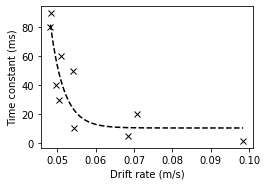

In [123]:
# Calculates the drift rates of the curves for different tau values and 
# fits a curve to the resulting data points and 
# then predicts what tau would give us the 3.4cm/h drift rate of ants. 

# Optional placed temporalily here to use only a subset different than the above plot
# With this subset of taus produces better fitted curve because above 60ms the drift rate increases again
# option : 1-11 are for poisson_neuron_noise=1.4 and neurons_nums=256
# option : 12-20 are for poisson_neuron_noise=0.15 and neurons_nums=512
# option : 21- are for poisson_neuron_noise=0.05 and neurons_nums=512
option = 10 # Good with 256 neurons at poisson_neuron_noise=1.4  achieves 0.034m/h with tau=62117s
#option = 14 # Good with 512 neurons at poisson_neuron_noise=0.15 achieves 0.034m/h with tau=1829s
#option = 20 # Good with 512 neurons at poisson_neuron_noise=0.15  achieves 0.034m/h with tau=20603566s
#option = 21  # Good with 512 neurons at poisson_neuron_noise=0.05  achieves 0.034m/h with tau=28s

if option >= 1 and option <= 11:
    neurons_nums = [256] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [1.4]
elif option >= 12 and option <=20:
    neurons_nums = [512] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.15]
elif option >= 21:
    neurons_nums = [512] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.05]

neurons_num = neurons_nums[0]

if option == 1 or option == 3 or option == 4:
    # Option 1 & 3
    # Option 1 : 0.6247697408821746s
    # Option 3 : 4.98631052591893s
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'][1:]
    start_time=0
    end_time=200
    percentage=0.1
if option == 2:
    # Option 2
    # Option 2 : 5510.134952119207s
    taus = ['complex', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms'][1:]
    start_time=10
    end_time=200
    percentage=0.1
if option == 3:
    start_time=0
    end_time=250
    percentage=0.1
if option == 4:
    start_time=0
    end_time=250
    percentage=0.2
if option == 5:
    start_time=0
    end_time=250
    percentage=0.2
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']
if option == 6:
    start_time=0
    end_time=258
    percentage=0.18
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']
if option == 7:
    start_time=2
    end_time=235
    percentage=0.30
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms']

# Exploratory
if option == 8:
    start_time=100
    end_time=220
    percentage=0.2
    taus = ['0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms']

# Exploratory
if option == 9:
    start_time=150
    end_time=250
    percentage=0.15
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']

# Exploratory
if option == 10: # A good selection?
    start_time=20
    end_time=235
    percentage=0.11
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '80ms', '90ms'] # Without 70ms

# Exploratory
if option == 11:
    start_time=150
    end_time=299
    percentage=0.1
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '80ms', '90ms'] # Without 70ms

# Exploratory with the new 512 neurons data set
if option == 12: #     9.296s    R2=0.515
    start_time=0
    end_time=250
    percentage=0.38
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 13: #    47.830s    R2=0.605
    start_time=10
    end_time=250
    percentage=0.40
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 14: # 1829.647s    R2=0.651
    start_time=20
    end_time=250
    percentage=0.25
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms Without 0.5ms => 1830s
    #taus = ['0.5ms', '1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms With 0.5ms 1595s
# Exploratory with the new 512 neurons data set
if option == 15: #  1810.837s    R2=0.629
    start_time=20
    end_time=250
    percentage=0.40
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 16: # High but not good fit to data points
    start_time=80
    end_time=240
    percentage=0.10
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 17: # High but not good fit to data points
    start_time=80
    end_time=250
    percentage=0.10
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 18: # High but not good fit to data points
    start_time=80
    end_time=270
    percentage=0.24
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 19: # High but not good fit to data points
    start_time=90
    end_time=250
    percentage=0.28
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 20: # 20603566.267s    R2=0.745 A wide range of values with lot of good nicelly gathered points around fitted curve 
    start_time=12
    end_time=245
    percentage=0.15
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms

# Exploratory with the new 512 neurons data set at poisson_noise=0.05
if option == 21: # 1.044s    R2=0.916
    start_time=110
    end_time=299
    percentage=0.10
    taus = ['0.5ms', '1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms'] 
    taus = ['0.5ms', '1ms', '10ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms'] 
    taus = ['0.5ms', '1ms', '10ms', '30ms', '40ms', '60ms', '70ms'] 
    
def calc_drift_rate(poisson_neuron_noises, models, taus, start_time=0, end_time=200, percentage=0.1):
    results_data = {}
    for poisson_neuron_noise in poisson_neuron_noises:
        # Collect data for plot
        results_data[poisson_neuron_noise] = dict()
        print()
        print('Noise = ' + str(poisson_neuron_noise))
        for indx_i, model in enumerate(models):
            print()
            print(model + ' neuron model')
            print('=====================')
            trials_dict = data[()][model][poisson_neuron_noise]
            trials_dict_remapped = {}
            for tau in taus:
                trials_dict_remapped[tau] = data[()][model][poisson_neuron_noise][tau][neurons_num]
            trials_dict_ammended = calc_theta_mean_absolute_deviation_rate(trials_dict_remapped, taus, start_time=start_time, end_time=end_time, percentage=percentage)
            print('---------------------')
            print('Not scaled output')
            print('---------------------')
            print_theta_mean_absolute_deviation_rate(trials_dict_ammended, taus, plot_key_str='Neurons', plot_key_units='number')
            #print_theta_mean_absolute_deviation_rate(trials_dict_ammended, taus, plot_key_str='Noise', plot_key_units='(1/SNR)')
            print('---------------------')
            print('Scaled output')
            print('---------------------')
            print_theta_mean_absolute_deviation_rate_scaled(trials_dict_ammended, taus, scale=[(0, 360), (0, 100)], plot_key_str='Neurons', plot_key_units='number')

            # Collect data for plot
            results_data[poisson_neuron_noise][model] = dict()
            results_data[poisson_neuron_noise][model]['x'] = []
            results_data[poisson_neuron_noise][model]['y'] = []
            for tau in taus:
                results_data[poisson_neuron_noise][model]['x'].append(tau.replace('ms', ''))
                results_data[poisson_neuron_noise][model]['y'].append(trials_dict_ammended[tau]['theta_mean_absolute_deviation_rate'])
    return results_data

results_data = calc_drift_rate(poisson_neuron_noises, models, taus, start_time=start_time, end_time=end_time, percentage=percentage)

# Option ?
# New attempt
# Fit curves to the data points
# Drift rate in meters/sec

#plt.rcParams.update({'font.size': 14}) # Change the font size

# Requirements calculation:
t_req = 60 * 60 # Default t_req = 1h
drift_max_percent = 0.01 # Default 1%

# Set condition
condition = 2 # condition = 1 or 2: 1 is for 1m/100m while 2 for 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)
if condition == 1:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.01 # 1% => 1m/100m
if condition == 2:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.00034 # 0.034% => 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)

range_max = 360
range_max_new = 100

drift_max = drift_max_percent * range_max_new
drift_rate_max = drift_max / t_req
x_req = drift_rate_max
print('Max tolerable drift rate {}m/h ({}m/s)'.format(drift_max, drift_rate_max))

def func_exp_1(x, a, b, c):
    """ Exponential function """
    y = a * np.exp(-b*x) + c
    return y

# Plot only for 0.005 synaptic noise
#poisson_neuron_noise = 0.005
#poisson_neuron_noise = 0.0001
#poisson_neuron_noise = 1.0
#poisson_neuron_noise = 1.4
#poisson_neuron_noises = [1.4]

# Newly collected data with 256 neurons
#poisson_neuron_noises = [0.3]

# Newly collected data with 512 neurons
#poisson_neuron_noises = [0.15]

poisson_neuron_noise = poisson_neuron_noises[0]

for indx_i, model in enumerate(models):

    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    
    x = np.array(results_data[poisson_neuron_noise][model]['y'])
    y = np.array(results_data[poisson_neuron_noise][model]['x'])
    y = y.astype(np.float) # Convert the array of strings to array of numbers
    x = scale_circ_to_line(x, scale=[(0, range_max), (0, range_max_new)])
    
    # Plot data points
    #plt.plot(x, y, linestyle='', marker='.', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.plot(x, y, 'xk', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.xlabel('Diffusion rate (m/s)')
    plt.ylabel('Time constant (ms)')
    
    # Fit a curve to the data points
    params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA':
        params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'EC_LV_1':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE-TAU2':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA-TAU':
        params0 = [20, 20, -2] # Initial guess of parameter values to optimize [a, b, c]
        params0 = [4946.138,     69.046,   -4.955]
    
    
    # Method 1
    Method1 = False
    if Method1:
        params, conv  = curve_fit(func_exp_1, x, y, params0) # fit function parameters
        # Print the fitted parameters
        print('Optimal parameters')
        print('y=a*exp(-b*x)+c, [a, b, c] = {}'.format(params))
        # Calculate fitted curve prediction
        y_prime = func_exp_1(x, params[0], params[1], params[2])
        # Calculate r^2
        print('R^2 = {}'.format(r2_score(y, y_prime)))
            # Calculate required number of neurons
        y_req = func_exp_1(x_req, params[0], params[1], params[2])
        print('For ensuring drift of less than {}m/h ({}m/s) we need {} excitatory neurons'.format(drift_max, x_req, int(np.round(y_req))))
        # Plot fitted curve for more sample points to make it smooth
        #x_prime = np.linspace(np.min(x), np.max(x), num=1000, endpoint=True)
        max_lim = 1
        max_lim = np.max(x)
        x_prime = np.linspace(0, max_lim, num=1000, endpoint=True)
        # Calculate fitted curve prediction
        y_prime = func_exp_1(x_prime, params[0], params[1], params[2])
        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '-k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    
    
    # Method 2
    Method2 = True
    if Method2:
        x_prime, y_prime, params, r2 = regress(x, y, func_exp_1, params0, func_str = 'a*exp(-b*x)+c, [a, b, c] = {}')
        y_req = func_exp_1(x_req, *params)
        print('For ensuring drift of less than {}m/h ({}m/s) we need a time constant of {}s'.format(drift_max, x_req, y_req/1000))

        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '--k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    
    # 
    #plt.legend(loc='best')
    plt.xlabel('Drift rate (m/s)')
    plt.ylabel('Time constant (ms)')
    #plt.xlim([0, max_lim])
    
    if SAVE_PLOT:
        fig.savefig(os.path.join('Data/Plots/', 'pub_' + model + '_neuron_tau_vs_dispersion_rate_range' + str(range_max_new) + 'm' + '_noise' + str(poisson_neuron_noise) + '_neurons' + str(neurons_num)+ '_meas' + str(start_time) + '-' + str(end_time) + 's' + '-' + str(percentage) + 'prc' + '_projtau' + str(int(np.round(y_req/1000))) + 's' + figs_extension), bbox_inches='tight', dpi=300)
        

In [21]:
# Explores parameters for calculating drift rates from the curves 
# that results in best meaurements for fitting the curve to the data points.
# We want to select the parameters that result to a large "required tau" and "R2 score" 
# because we know the tau must be really large to achieve the stability required 
# so anything else must be just an artifact of our simulations and estimation. 

import contextlib

optimise_option = 1 # Explore with poisson_neuron_noise=1.4 and neurons_nums=256
optimise_option = 2 # Explore with poisson_neuron_noise=0.15 and neurons_nums=512
optimise_option = 3 # Explore with poisson_neuron_noise=0.05 and neurons_nums=512

#taus = ['0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']
#for start_time in [0]:
#    for end_time in [257, 258, 259, 260]:
#        for percentage in np.linspace(0.1, 0.2, 11).tolist(): #[0.1, 0.15, 0.2, 0.25, 0.3]:

# These were used to explore with poisson_neuron_noise=1.4 and neurons_nums=256
if optimise_option == 1:
    poisson_neuron_noises = [1.4]
    taus = ['0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms']
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '80ms', '90ms']

# These were used to explore with poisson_neuron_noise=0.15 and neurons_nums=512
if optimise_option == 2:
    poisson_neuron_noises = [0.15]
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']
    taus = ['0.5ms', '1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']

# These were used to explore with poisson_neuron_noise=0.05 and neurons_nums=512
if optimise_option == 3:
    poisson_neuron_noises = [0.05]
    taus = ['0.5ms', '1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms'] 
    taus = ['0.5ms', '1ms', '10ms', '30ms', '40ms', '60ms', '70ms'] 

    
poisson_neuron_noise = poisson_neuron_noises[0]
# neurons_nums is not used in this code so we do not set it

results_data_struc = []
for start_time in [100, 110, 120, 130, 140, 150]:
    for end_time in [240, 250, 260, 270, 280, 290, 299]:
        for percentage in np.linspace(0.05, 0.5, 101).tolist(): #[0.1, 0.15, 0.2, 0.25, 0.3]:
            with contextlib.redirect_stdout(None):
                print('start_time={:6}, end_time={:6}, percentage={:6}'.format(start_time, end_time, percentage))
                results_data = calc_drift_rate(poisson_neuron_noises, models, taus, start_time=start_time, end_time=end_time, percentage=percentage)
            x = np.array(results_data[poisson_neuron_noise][model]['y'])
            y = np.array(results_data[poisson_neuron_noise][model]['x'])
            y = y.astype(np.float) # Convert the array of strings to array of numbers
            x = scale_circ_to_line(x, scale=[(0, range_max), (0, range_max_new)])
            try:
                with contextlib.redirect_stdout(None):
                    x_prime, y_prime, params, r2 = regress(x, y, func_exp_1, params0, func_str = 'a*exp(-b*x)+c, [a, b, c] = {}')
                    y_req = func_exp_1(x_req, *params)
                #print('For ensuring drift of less than {}m/h ({}m/s) we need a time constant of {}s'.format(drift_max, x_req, y_req/1000))
                results_data_struc.append([start_time, end_time, percentage, y_req/1000, r2])
            except:
                pass

print('{:^8} {:^8} {:^8} {:^8} {:^8}'.format('start',    'end',      'percent', 'required', 'R2 score'))
print('{:^8} {:^8} {:^8} {:^8} {:^8}'.format('time (s)', 'time (s)', '(%)',        'tau (s)',  'R2 score'))
print('{:^8} {:^8} {:^8} {:^8} {:^8}'.format(*(['-'*8]*5)))
for item in results_data_struc:
    print('{:8} {:8} {:8.2f} {:8.3f} {:8.3f}'.format(*item))


WARNING    /Users/john/Library/Python/3.7/lib/python/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 [py.warnings]
WARNING    /Users/john/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 [py.warnings]
WARNING    /Users/john/Library/Python/3.7/lib/python/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 [py.warnings]
WARNING    /Users/john/Library/Python/3.7/lib/python/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 [py.warnings]
WARNING    /Users/john/Library/Python/3.7/lib/python/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 [py.warnings]
WARNING    /Users/john/Library/Python/3.7/lib/python/site-packages/num

 start     end    percent  required R2 score
time (s) time (s)   (%)    tau (s)  R2 score
-------- -------- -------- -------- --------
     100      240     0.07   -0.061    0.026
     100      240     0.08   -0.061    0.026
     100      240     0.08   -0.061    0.026
     100      240     0.09   -0.061    0.026
     100      240     0.09   -0.061    0.026
     100      240     0.10   -0.061    0.026
     100      240     0.10   -0.061    0.026
     100      240     0.10   -0.061    0.026
     100      240     0.11   -0.061    0.026
     100      240     0.11   -0.061    0.026
     100      240     0.12   -0.061    0.026
     100      240     0.12   -0.061    0.026
     100      240     0.13   -0.061    0.026
     100      240     0.13   -0.061    0.026
     100      240     0.14   -0.061    0.026
     100      240     0.14   -0.061    0.026
     100      240     0.14   -0.070    0.029
     100      240     0.15   -0.070    0.029
     100      240     0.15   -0.070    0.029
     100  

### That was run on 15-16 September 2021 before introducing the extra trials used in the runs above

In [301]:
# Optional placed temporalily here to use only a subset different than the above plot
# With this subset of taus produces better fitted curve because above 60ms the drift rate increases again
option = 7
if option == 1 or option == 3 or option == 4:
    # Option 1 & 3
    # Option 1 : 0.6247697408821746s
    # Option 3 : 4.98631052591893s
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'][1:]
    start_time=0
    end_time=200
    percentage=0.1
if option == 2:
    # Option 2
    # Option 2 : 5510.134952119207s
    taus = ['complex', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms'][1:]
    start_time=10
    end_time=200
    percentage=0.1
if option == 3:
    start_time=0
    end_time=250
    percentage=0.1
if option == 4:
    start_time=0
    end_time=250
    percentage=0.2
if option == 5:
    start_time=0
    end_time=250
    percentage=0.2
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']
if option == 6:
    start_time=0
    end_time=258
    percentage=0.18
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']
if option == 7:
    start_time=0
    end_time=235
    percentage=0.32
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms']

def calc_drift_rate(poisson_neuron_noises, models, taus, start_time=0, end_time=200, percentage=0.1):
    results_data = {}
    for poisson_neuron_noise in poisson_neuron_noises:
        # Collect data for plot
        results_data[poisson_neuron_noise] = dict()
        print()
        print('Noise = ' + str(poisson_neuron_noise))
        for indx_i, model in enumerate(models):
            print()
            print(model + ' neuron model')
            print('=====================')
            trials_dict = data[()][model][poisson_neuron_noise]
            trials_dict_remapped = {}
            for tau in taus:
                trials_dict_remapped[tau] = data[()][model][poisson_neuron_noise][tau][neurons_num]
            trials_dict_ammended = calc_theta_mean_absolute_deviation_rate(trials_dict_remapped, taus, start_time=start_time, end_time=end_time, percentage=percentage)
            print('---------------------')
            print('Not scaled output')
            print('---------------------')
            print_theta_mean_absolute_deviation_rate(trials_dict_ammended, taus, plot_key_str='Neurons', plot_key_units='number')
            #print_theta_mean_absolute_deviation_rate(trials_dict_ammended, taus, plot_key_str='Noise', plot_key_units='(1/SNR)')
            print('---------------------')
            print('Scaled output')
            print('---------------------')
            print_theta_mean_absolute_deviation_rate_scaled(trials_dict_ammended, taus, scale=[(0, 360), (0, 100)], plot_key_str='Neurons', plot_key_units='number')

            # Collect data for plot
            results_data[poisson_neuron_noise][model] = dict()
            results_data[poisson_neuron_noise][model]['x'] = []
            results_data[poisson_neuron_noise][model]['y'] = []
            for tau in taus:
                results_data[poisson_neuron_noise][model]['x'].append(tau.replace('ms', ''))
                results_data[poisson_neuron_noise][model]['y'].append(trials_dict_ammended[tau]['theta_mean_absolute_deviation_rate'])
    return results_data

results_data = calc_drift_rate(poisson_neuron_noises, models, taus, start_time=start_time, end_time=end_time, percentage=percentage)



Noise = 1.4

NMDA-TAU neuron model
---------------------
Not scaled output
---------------------
Neurons Drift rate
number    (°/s)   
1ms     0.40540435958906273
5ms     0.30742281508878316
10ms    0.2708307755232676
20ms    0.2952967067043621
30ms    0.23715518417512513
40ms    0.2286878027353941
50ms    0.2611808192581819
60ms    0.2321510884643826
70ms    0.24906418787007126
80ms    0.22735426602909678
90ms    0.22281675935408898
100ms   0.2405307256201928
---------------------
Scaled output
---------------------
Neurons Drift rate
number  (units/s) 
1ms     0.11261232210807298
5ms     0.08539522641355088
10ms    0.07523077097868545
20ms    0.08202686297343391
30ms    0.06587644004864587
40ms    0.06352438964872058
50ms    0.0725502275717172
60ms    0.0644864134623285
70ms    0.06918449663057534
80ms    0.06315396278586022
90ms    0.06189354426502472
100ms   0.06681409045005356


In [299]:
# Explore parameters for calculating drift rate that results in best meaurements for fitting the curve to the data points

import contextlib

#taus = ['0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']
#for start_time in [0]:
#    for end_time in [257, 258, 259, 260]:
#        for percentage in np.linspace(0.1, 0.2, 11).tolist(): #[0.1, 0.15, 0.2, 0.25, 0.3]:
taus = ['0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms']

results_data_struc = []
for start_time in [0]:
    for end_time in [235]:
        for percentage in np.linspace(0.3, 0.34, 101).tolist(): #[0.1, 0.15, 0.2, 0.25, 0.3]:
            with contextlib.redirect_stdout(None):
                print('start_time={:6}, end_time={:6}, percentage={:6}'.format(start_time, end_time, percentage))
                results_data = calc_drift_rate(poisson_neuron_noises, models, taus, start_time=start_time, end_time=end_time, percentage=percentage)
            x = np.array(results_data[poisson_neuron_noise][model]['y'])
            y = np.array(results_data[poisson_neuron_noise][model]['x'])
            y = y.astype(np.float) # Convert the array of strings to array of numbers
            x = scale_circ_to_line(x, scale=[(0, range_max), (0, range_max_new)])
            try:
                with contextlib.redirect_stdout(None):
                    x_prime, y_prime, params, r2 = regress(x, y, func_exp_1, params0, func_str = 'a*exp(-b*x)+c, [a, b, c] = {}')
                    y_req = func_exp_1(x_req, *params)
                #print('For ensuring drift of less than {}m/h ({}m/s) we need a time constant of {}s'.format(drift_max, x_req, y_req/1000))
                results_data_struc.append([start_time, end_time, percentage, y_req/1000, r2])
            except:
                pass

print('{:^8} {:^8} {:^8} {:^8} {:^8}'.format('start',    'end',      'percent', 'required', 'R2 score'))
print('{:^8} {:^8} {:^8} {:^8} {:^8}'.format('time (s)', 'time (s)', '(%)',        'tau (s)',  'R2 score'))
print('{:^8} {:^8} {:^8} {:^8} {:^8}'.format(*(['-'*8]*5)))
for item in results_data_struc:
    print('{:8} {:8} {:8.2f} {:8.3f} {:8.3f}'.format(*item))


 start     end    percent  required R2 score
time (s) time (s)   (%)    tau (s)  R2 score
-------- -------- -------- -------- --------
       0      235     0.30    2.986    0.651
       0      235     0.30    2.986    0.651
       0      235     0.30    2.986    0.651
       0      235     0.30    2.986    0.651
       0      235     0.30    2.986    0.651
       0      235     0.30    2.986    0.651
       0      235     0.30    2.986    0.651
       0      235     0.30    2.986    0.651
       0      235     0.30    2.986    0.651
       0      235     0.30    2.986    0.651
       0      235     0.30    2.986    0.651
       0      235     0.30    2.986    0.651
       0      235     0.30    2.986    0.651
       0      235     0.31    2.986    0.651
       0      235     0.31    2.986    0.651
       0      235     0.31    2.986    0.651
       0      235     0.31    2.986    0.651
       0      235     0.31    2.986    0.651
       0      235     0.31    2.986    0.651
       0  

Max tolerable drift rate 0.034m/h (9.444444444444445e-06m/s)
Optimal parameters
a*exp(-b*x)+c, [a, b, c] = [2939.89307183   56.80258286   -8.81663611]
R^2 = 0.5982615604605823
For ensuring drift of less than 0.034m/h (9.444444444444445e-06m/s) we need a time constant of 2.929499697674528s


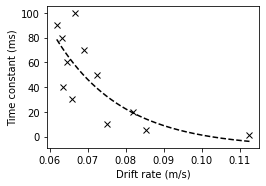

In [302]:
# Option 7
# New attempt
# Fit curves to the data points
# Drift rate in meters/sec

#plt.rcParams.update({'font.size': 14}) # Change the font size

# Requirements calculation:
t_req = 60 * 60 # Default t_req = 1h
drift_max_percent = 0.01 # Default 1%

# Set condition
condition = 2 # condition = 1 or 2: 1 is for 1m/100m while 2 for 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)
if condition == 1:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.01 # 1% => 1m/100m
if condition == 2:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.00034 # 0.034% => 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)

range_max = 360
range_max_new = 100

drift_max = drift_max_percent * range_max_new
drift_rate_max = drift_max / t_req
x_req = drift_rate_max
print('Max tolerable drift rate {}m/h ({}m/s)'.format(drift_max, drift_rate_max))

def func_exp_1(x, a, b, c):
    """ Exponential function """
    y = a * np.exp(-b*x) + c
    return y

# Plot only for 0.005 synaptic noise
poisson_neuron_noise = 0.005
poisson_neuron_noise = 0.0001
poisson_neuron_noise = 1.0
poisson_neuron_noise = 1.4

for indx_i, model in enumerate(models):

    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    
    x = np.array(results_data[poisson_neuron_noise][model]['y'])
    y = np.array(results_data[poisson_neuron_noise][model]['x'])
    y = y.astype(np.float) # Convert the array of strings to array of numbers
    x = scale_circ_to_line(x, scale=[(0, range_max), (0, range_max_new)])
    
    # Plot data points
    #plt.plot(x, y, linestyle='', marker='.', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.plot(x, y, 'xk', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.xlabel('Diffusion rate (m/s)')
    plt.ylabel('Time constant (ms)')
    
    # Fit a curve to the data points
    params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA':
        params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'EC_LV_1':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE-TAU2':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA-TAU':
        params0 = [20, 20, -2] # Initial guess of parameter values to optimize [a, b, c]
        params0 = [4946.138,     69.046,   -4.955]
    
    
    # Method 1
    Method1 = False
    if Method1:
        params, conv  = curve_fit(func_exp_1, x, y, params0) # fit function parameters
        # Print the fitted parameters
        print('Optimal parameters')
        print('y=a*exp(-b*x)+c, [a, b, c] = {}'.format(params))
        # Calculate fitted curve prediction
        y_prime = func_exp_1(x, params[0], params[1], params[2])
        # Calculate r^2
        print('R^2 = {}'.format(r2_score(y, y_prime)))
            # Calculate required number of neurons
        y_req = func_exp_1(x_req, params[0], params[1], params[2])
        print('For ensuring drift of less than {}m/h ({}m/s) we need {} excitatory neurons'.format(drift_max, x_req, int(np.round(y_req))))
        # Plot fitted curve for more sample points to make it smooth
        #x_prime = np.linspace(np.min(x), np.max(x), num=1000, endpoint=True)
        max_lim = 1
        max_lim = np.max(x)
        x_prime = np.linspace(0, max_lim, num=1000, endpoint=True)
        # Calculate fitted curve prediction
        y_prime = func_exp_1(x_prime, params[0], params[1], params[2])
        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '-k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    
    
    # Method 2
    Method2 = True
    if Method2:
        x_prime, y_prime, params, r2 = regress(x, y, func_exp_1, params0, func_str = 'a*exp(-b*x)+c, [a, b, c] = {}')
        y_req = func_exp_1(x_req, *params)
        print('For ensuring drift of less than {}m/h ({}m/s) we need a time constant of {}s'.format(drift_max, x_req, y_req/1000))

        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '--k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    
    # 
    #plt.legend(loc='best')
    plt.xlabel('Drift rate (m/s)')
    plt.ylabel('Time constant (ms)')
    #plt.xlim([0, max_lim])
    
    if SAVE_PLOT:
        fig.savefig(os.path.join('Data/Plots/', 'pub_' + model + '_neuron_tau_vs_dispersion_rate_range' + str(range_max_new) + 'm' + '_noise' + str(poisson_neuron_noise) + figs_extension), bbox_inches='tight', dpi=300)

Max tolerable drift rate 0.034m/h (9.444444444444445e-06m/s)
Optimal parameters
a*exp(-b*x)+c, [a, b, c] = [ 1.15229417e+04  8.25574058e+01 -5.25344037e+00]
R^2 = 0.7182524768421614
For ensuring drift of less than 0.034m/h (9.444444444444445e-06m/s) we need a time constant of 11.508707222311706s


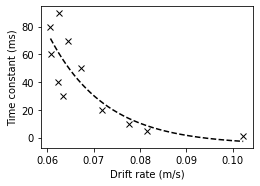

In [289]:
# Option 6
# New attempt
# Fit curves to the data points
# Drift rate in meters/sec

#plt.rcParams.update({'font.size': 14}) # Change the font size

# Requirements calculation:
t_req = 60 * 60 # Default t_req = 1h
drift_max_percent = 0.01 # Default 1%

# Set condition
condition = 2 # condition = 1 or 2: 1 is for 1m/100m while 2 for 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)
if condition == 1:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.01 # 1% => 1m/100m
if condition == 2:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.00034 # 0.034% => 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)

range_max = 360
range_max_new = 100

drift_max = drift_max_percent * range_max_new
drift_rate_max = drift_max / t_req
x_req = drift_rate_max
print('Max tolerable drift rate {}m/h ({}m/s)'.format(drift_max, drift_rate_max))

def func_exp_1(x, a, b, c):
    """ Exponential function """
    y = a * np.exp(-b*x) + c
    return y

# Plot only for 0.005 synaptic noise
poisson_neuron_noise = 0.005
poisson_neuron_noise = 0.0001
poisson_neuron_noise = 1.0
poisson_neuron_noise = 1.4

for indx_i, model in enumerate(models):

    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    
    x = np.array(results_data[poisson_neuron_noise][model]['y'])
    y = np.array(results_data[poisson_neuron_noise][model]['x'])
    y = y.astype(np.float) # Convert the array of strings to array of numbers
    x = scale_circ_to_line(x, scale=[(0, range_max), (0, range_max_new)])
    
    # Plot data points
    #plt.plot(x, y, linestyle='', marker='.', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.plot(x, y, 'xk', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.xlabel('Diffusion rate (m/s)')
    plt.ylabel('Time constant (ms)')
    
    # Fit a curve to the data points
    params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA':
        params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'EC_LV_1':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE-TAU2':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA-TAU':
        params0 = [20, 20, -2] # Initial guess of parameter values to optimize [a, b, c]
        params0 = [4946.138,     69.046,   -4.955]
    
    
    # Method 1
    Method1 = False
    if Method1:
        params, conv  = curve_fit(func_exp_1, x, y, params0) # fit function parameters
        # Print the fitted parameters
        print('Optimal parameters')
        print('y=a*exp(-b*x)+c, [a, b, c] = {}'.format(params))
        # Calculate fitted curve prediction
        y_prime = func_exp_1(x, params[0], params[1], params[2])
        # Calculate r^2
        print('R^2 = {}'.format(r2_score(y, y_prime)))
            # Calculate required number of neurons
        y_req = func_exp_1(x_req, params[0], params[1], params[2])
        print('For ensuring drift of less than {}m/h ({}m/s) we need {} excitatory neurons'.format(drift_max, x_req, int(np.round(y_req))))
        # Plot fitted curve for more sample points to make it smooth
        #x_prime = np.linspace(np.min(x), np.max(x), num=1000, endpoint=True)
        max_lim = 1
        max_lim = np.max(x)
        x_prime = np.linspace(0, max_lim, num=1000, endpoint=True)
        # Calculate fitted curve prediction
        y_prime = func_exp_1(x_prime, params[0], params[1], params[2])
        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '-k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    
    
    # Method 2
    Method2 = True
    if Method2:
        x_prime, y_prime, params, r2 = regress(x, y, func_exp_1, params0, func_str = 'a*exp(-b*x)+c, [a, b, c] = {}')
        y_req = func_exp_1(x_req, *params)
        print('For ensuring drift of less than {}m/h ({}m/s) we need a time constant of {}s'.format(drift_max, x_req, y_req/1000))

        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '--k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    
    # 
    #plt.legend(loc='best')
    plt.xlabel('Drift rate (m/s)')
    plt.ylabel('Time constant (ms)')
    #plt.xlim([0, max_lim])
    
    if SAVE_PLOT:
        fig.savefig(os.path.join('Data/Plots/', 'pub_' + model + '_neuron_tau_vs_dispersion_rate_range' + str(range_max_new) + 'm' + '_noise' + str(poisson_neuron_noise) + figs_extension), bbox_inches='tight', dpi=300)

Max tolerable drift rate 0.034m/h (9.444444444444445e-06m/s)
Optimal parameters
a*exp(-b*x)+c, [a, b, c] = [4946.17695328   69.04641964   -4.95521788]
R^2 = 0.782474974441208
For ensuring drift of less than 0.034m/h (9.444444444444445e-06m/s) we need a time constant of 4.937997359738869s


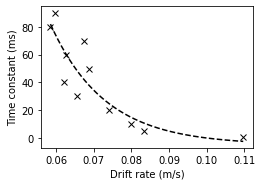

In [213]:
# Option 4
# New attempt
# Fit curves to the data points
# Drift rate in meters/sec

#plt.rcParams.update({'font.size': 14}) # Change the font size

# Requirements calculation:
t_req = 60 * 60 # Default t_req = 1h
drift_max_percent = 0.01 # Default 1%

# Set condition
condition = 2 # condition = 1 or 2: 1 is for 1m/100m while 2 for 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)
if condition == 1:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.01 # 1% => 1m/100m
if condition == 2:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.00034 # 0.034% => 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)

range_max = 360
range_max_new = 100

drift_max = drift_max_percent * range_max_new
drift_rate_max = drift_max / t_req
x_req = drift_rate_max
print('Max tolerable drift rate {}m/h ({}m/s)'.format(drift_max, drift_rate_max))

def func_exp_1(x, a, b, c):
    """ Exponential function """
    y = a * np.exp(-b*x) + c
    return y

# Plot only for 0.005 synaptic noise
poisson_neuron_noise = 0.005
poisson_neuron_noise = 0.0001
poisson_neuron_noise = 1.0
poisson_neuron_noise = 1.4

for indx_i, model in enumerate(models):

    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    
    x = np.array(results_data[poisson_neuron_noise][model]['y'])
    y = np.array(results_data[poisson_neuron_noise][model]['x'])
    y = y.astype(np.float) # Convert the array of strings to array of numbers
    x = scale_circ_to_line(x, scale=[(0, range_max), (0, range_max_new)])
    
    # Plot data points
    #plt.plot(x, y, linestyle='', marker='.', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.plot(x, y, 'xk', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.xlabel('Diffusion rate (m/s)')
    plt.ylabel('Time constant (ms)')
    
    # Fit a curve to the data points
    params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA':
        params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'EC_LV_1':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE-TAU2':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA-TAU':
        params0 = [20, 20, -2] # Initial guess of parameter values to optimize [a, b, c]
        params0 = [4946.138,     69.046,   -4.955]
    
    
    # Method 1
    Method1 = False
    if Method1:
        params, conv  = curve_fit(func_exp_1, x, y, params0) # fit function parameters
        # Print the fitted parameters
        print('Optimal parameters')
        print('y=a*exp(-b*x)+c, [a, b, c] = {}'.format(params))
        # Calculate fitted curve prediction
        y_prime = func_exp_1(x, params[0], params[1], params[2])
        # Calculate r^2
        print('R^2 = {}'.format(r2_score(y, y_prime)))
            # Calculate required number of neurons
        y_req = func_exp_1(x_req, params[0], params[1], params[2])
        print('For ensuring drift of less than {}m/h ({}m/s) we need {} excitatory neurons'.format(drift_max, x_req, int(np.round(y_req))))
        # Plot fitted curve for more sample points to make it smooth
        #x_prime = np.linspace(np.min(x), np.max(x), num=1000, endpoint=True)
        max_lim = 1
        max_lim = np.max(x)
        x_prime = np.linspace(0, max_lim, num=1000, endpoint=True)
        # Calculate fitted curve prediction
        y_prime = func_exp_1(x_prime, params[0], params[1], params[2])
        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '-k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    
    
    # Method 2
    Method2 = True
    if Method2:
        x_prime, y_prime, params, r2 = regress(x, y, func_exp_1, params0, func_str = 'a*exp(-b*x)+c, [a, b, c] = {}')
        y_req = func_exp_1(x_req, *params)
        print('For ensuring drift of less than {}m/h ({}m/s) we need a time constant of {}s'.format(drift_max, x_req, y_req/1000))

        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '--k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    
    # 
    #plt.legend(loc='best')
    plt.xlabel('Drift rate (m/s)')
    plt.ylabel('Time constant (ms)')
    #plt.xlim([0, max_lim])
    
    if SAVE_PLOT:
        fig.savefig(os.path.join('Data/Plots/', 'pub_' + model + '_neuron_tau_vs_dispersion_rate_range' + str(range_max_new) + 'm' + '_noise' + str(poisson_neuron_noise) + figs_extension), bbox_inches='tight', dpi=300)

Max tolerable drift rate 0.034m/h (9.444444444444445e-06m/s)
Optimal parameters
a*exp(-b*x)+c, [a, b, c] = [4994.54901654   68.44806797   -5.01078795]
R^2 = 0.7997654472508533
For ensuring drift of less than 0.034m/h (9.444444444444445e-06m/s) we need a time constant of 4.98631052591893s


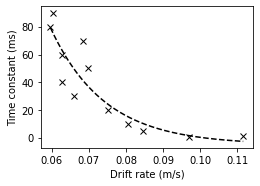

In [165]:
# Option 3
# Plotted with trials_dict_ammended = calc_theta_mean_absolute_deviation_rate(trials_dict_remapped, taus, start_time=0, end_time=200, percentage=0.1) above
# New attempt
# Fit curves to the data points
# Drift rate in meters/sec

#plt.rcParams.update({'font.size': 14}) # Change the font size

# Requirements calculation:
t_req = 60 * 60 # Default t_req = 1h
drift_max_percent = 0.01 # Default 1%

# Set condition
condition = 2 # condition = 1 or 2: 1 is for 1m/100m while 2 for 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)
if condition == 1:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.01 # 1% => 1m/100m
if condition == 2:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.00034 # 0.034% => 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)

range_max = 360
range_max_new = 100

drift_max = drift_max_percent * range_max_new
drift_rate_max = drift_max / t_req
x_req = drift_rate_max
print('Max tolerable drift rate {}m/h ({}m/s)'.format(drift_max, drift_rate_max))

def func_exp_1(x, a, b, c):
    """ Exponential function """
    y = a * np.exp(-b*x) + c
    return y

# Plot only for 0.005 synaptic noise
poisson_neuron_noise = 0.005
poisson_neuron_noise = 0.0001
poisson_neuron_noise = 1.0
poisson_neuron_noise = 1.4

for indx_i, model in enumerate(models):

    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    
    x = np.array(results_data[poisson_neuron_noise][model]['y'])
    y = np.array(results_data[poisson_neuron_noise][model]['x'])
    y = y.astype(np.float) # Convert the array of strings to array of numbers
    x = scale_circ_to_line(x, scale=[(0, range_max), (0, range_max_new)])
    
    # Plot data points
    #plt.plot(x, y, linestyle='', marker='.', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.plot(x, y, 'xk', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.xlabel('Diffusion rate (m/s)')
    plt.ylabel('Time constant (ms)')
    
    # Fit a curve to the data points
    params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA':
        params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'EC_LV_1':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE-TAU2':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA-TAU':
        params0 = [20, 20, -2] # Initial guess of parameter values to optimize [a, b, c]
        params0 = [8015.316, 103.743, 1.9]
    
    
    # Method 1
    Method1 = False
    if Method1:
        params, conv  = curve_fit(func_exp_1, x, y, params0) # fit function parameters
        # Print the fitted parameters
        print('Optimal parameters')
        print('y=a*exp(-b*x)+c, [a, b, c] = {}'.format(params))
        # Calculate fitted curve prediction
        y_prime = func_exp_1(x, params[0], params[1], params[2])
        # Calculate r^2
        print('R^2 = {}'.format(r2_score(y, y_prime)))
            # Calculate required number of neurons
        y_req = func_exp_1(x_req, params[0], params[1], params[2])
        print('For ensuring drift of less than {}m/h ({}m/s) we need {} excitatory neurons'.format(drift_max, x_req, int(np.round(y_req))))
        # Plot fitted curve for more sample points to make it smooth
        #x_prime = np.linspace(np.min(x), np.max(x), num=1000, endpoint=True)
        max_lim = 1
        max_lim = np.max(x)
        x_prime = np.linspace(0, max_lim, num=1000, endpoint=True)
        # Calculate fitted curve prediction
        y_prime = func_exp_1(x_prime, params[0], params[1], params[2])
        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '-k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    
    
    # Method 2
    Method2 = True
    if Method2:
        x_prime, y_prime, params, r2 = regress(x, y, func_exp_1, params0, func_str = 'a*exp(-b*x)+c, [a, b, c] = {}')
        y_req = func_exp_1(x_req, *params)
        print('For ensuring drift of less than {}m/h ({}m/s) we need a time constant of {}s'.format(drift_max, x_req, y_req/1000))

        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '--k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')

    # 
    #plt.legend(loc='best')
    plt.xlabel('Drift rate (m/s)')
    plt.ylabel('Time constant (ms)')
    #plt.xlim([0, max_lim])
    
    if SAVE_PLOT:
        fig.savefig(os.path.join('Data/Plots/', 'pub_' + model + '_neuron_tau_vs_dispersion_rate_range' + str(range_max_new) + 'm' + '_noise' + str(poisson_neuron_noise) + figs_extension), bbox_inches='tight', dpi=300)

In [ ]:
# This includes only a subset of the data points without the extremes
# With this subset of taus produces better fitted curve because above 60ms the drift rate increases again
#taus = ['complex', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms'][1:]

Max tolerable drift rate 0.034m/h (9.444444444444445e-06m/s)
Optimal parameters
a*exp(-b*x)+c, [a, b, c] = [5.52040459e+06 1.97258215e+02 5.27484039e+00]
R^2 = 0.8490356562020336
For ensuring drift of less than 0.034m/h (9.444444444444445e-06m/s) we need a time constant of 5510.134952119207s


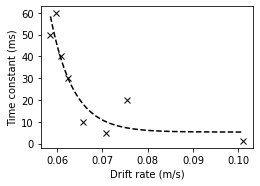

In [136]:
# Option 2
# Plotted with trials_dict_ammended = calc_theta_mean_absolute_deviation_rate(trials_dict_remapped, taus, start_time=10, end_time=200, percentage=0.1) above
# New attempt
# Fit curves to the data points
# Drift rate in meters/sec

#plt.rcParams.update({'font.size': 14}) # Change the font size

# Requirements calculation:
t_req = 60 * 60 # Default t_req = 1h
drift_max_percent = 0.01 # Default 1%

# Set condition
condition = 2 # condition = 1 or 2: 1 is for 1m/100m while 2 for 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)
if condition == 1:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.01 # 1% => 1m/100m
if condition == 2:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.00034 # 0.034% => 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)

range_max = 360
range_max_new = 100

drift_max = drift_max_percent * range_max_new
drift_rate_max = drift_max / t_req
x_req = drift_rate_max
print('Max tolerable drift rate {}m/h ({}m/s)'.format(drift_max, drift_rate_max))

def func_exp_1(x, a, b, c):
    """ Exponential function """
    y = a * np.exp(-b*x) + c
    return y

# Plot only for 0.005 synaptic noise
poisson_neuron_noise = 0.005
poisson_neuron_noise = 0.0001
poisson_neuron_noise = 1.0
poisson_neuron_noise = 1.4

for indx_i, model in enumerate(models):

    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    
    x = np.array(results_data[poisson_neuron_noise][model]['y'])
    y = np.array(results_data[poisson_neuron_noise][model]['x'])
    y = y.astype(np.float) # Convert the array of strings to array of numbers
    x = scale_circ_to_line(x, scale=[(0, range_max), (0, range_max_new)])
    
    # Plot data points
    #plt.plot(x, y, linestyle='', marker='.', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.plot(x, y, 'xk', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.xlabel('Diffusion rate (m/s)')
    plt.ylabel('Time constant (ms)')
    
    # Fit a curve to the data points
    params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA':
        params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'EC_LV_1':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE-TAU2':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA-TAU':
        params0 = [20, 20, -2] # Initial guess of parameter values to optimize [a, b, c]
    
    
    # Method 1
    Method1 = False
    if Method1:
        params, conv  = curve_fit(func_exp_1, x, y, params0) # fit function parameters
        # Print the fitted parameters
        print('Optimal parameters')
        print('y=a*exp(-b*x)+c, [a, b, c] = {}'.format(params))
        # Calculate fitted curve prediction
        y_prime = func_exp_1(x, params[0], params[1], params[2])
        # Calculate r^2
        print('R^2 = {}'.format(r2_score(y, y_prime)))
            # Calculate required number of neurons
        y_req = func_exp_1(x_req, params[0], params[1], params[2])
        print('For ensuring drift of less than {}m/h ({}m/s) we need {} excitatory neurons'.format(drift_max, x_req, int(np.round(y_req))))
        # Plot fitted curve for more sample points to make it smooth
        #x_prime = np.linspace(np.min(x), np.max(x), num=1000, endpoint=True)
        max_lim = 1
        max_lim = np.max(x)
        x_prime = np.linspace(0, max_lim, num=1000, endpoint=True)
        # Calculate fitted curve prediction
        y_prime = func_exp_1(x_prime, params[0], params[1], params[2])
        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '-k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    
    
    # Method 2
    Method2 = True
    if Method2:
        x_prime, y_prime, params, r2 = regress(x, y, func_exp_1, params0, func_str = 'a*exp(-b*x)+c, [a, b, c] = {}')
        y_req = func_exp_1(x_req, *params)
        print('For ensuring drift of less than {}m/h ({}m/s) we need a time constant of {}s'.format(drift_max, x_req, y_req/1000))

        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '--k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')

    # 
    #plt.legend(loc='best')
    plt.xlabel('Drift rate (m/s)')
    plt.ylabel('Time constant (ms)')
    #plt.xlim([0, max_lim])
    
    if SAVE_PLOT:
        fig.savefig(os.path.join('Data/Plots/', 'pub_' + model + '_neuron_tau_vs_dispersion_rate_range' + str(range_max_new) + 'm' + '_noise' + str(poisson_neuron_noise) + figs_extension), bbox_inches='tight', dpi=300)

In [ ]:
# The following includes all data points
# taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms', '1000ms', '10000ms', '100000ms'][1:13]

Max tolerable drift rate 0.034m/h (9.444444444444445e-06m/s)
Optimal parameters
a*exp(-b*x)+c, [a, b, c] = [661.84723331  26.60009127 -36.911242  ]
R^2 = 0.4986411367108585
For ensuring drift of less than 0.034m/h (9.444444444444445e-06m/s) we need a time constant of 0.6247697408821746s


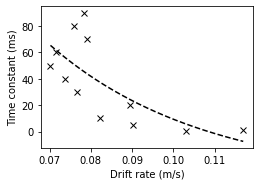

In [131]:
# Option 1
# Plotted with trials_dict_ammended = calc_theta_mean_absolute_deviation_rate(trials_dict_remapped, taus, start_time=0, end_time=200, percentage=0.1) above
# New attempt
# Fit curves to the data points
# Drift rate in meters/sec

#plt.rcParams.update({'font.size': 14}) # Change the font size

# Requirements calculation:
t_req = 60 * 60 # Default t_req = 1h
drift_max_percent = 0.01 # Default 1%

# Set condition
condition = 2 # condition = 1 or 2: 1 is for 1m/100m while 2 for 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)
if condition == 1:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.01 # 1% => 1m/100m
if condition == 2:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.00034 # 0.034% => 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)

range_max = 360
range_max_new = 100

drift_max = drift_max_percent * range_max_new
drift_rate_max = drift_max / t_req
x_req = drift_rate_max
print('Max tolerable drift rate {}m/h ({}m/s)'.format(drift_max, drift_rate_max))

def func_exp_1(x, a, b, c):
    """ Exponential function """
    y = a * np.exp(-b*x) + c
    return y

# Plot only for 0.005 synaptic noise
poisson_neuron_noise = 0.005
poisson_neuron_noise = 0.0001
poisson_neuron_noise = 1.0
poisson_neuron_noise = 1.4

for indx_i, model in enumerate(models):

    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    
    x = np.array(results_data[poisson_neuron_noise][model]['y'])
    y = np.array(results_data[poisson_neuron_noise][model]['x'])
    y = y.astype(np.float) # Convert the array of strings to array of numbers
    x = scale_circ_to_line(x, scale=[(0, range_max), (0, range_max_new)])
    
    # Plot data points
    #plt.plot(x, y, linestyle='', marker='.', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.plot(x, y, 'xk', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.xlabel('Diffusion rate (m/s)')
    plt.ylabel('Time constant (ms)')
    
    # Fit a curve to the data points
    params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA':
        params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'EC_LV_1':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE-TAU2':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA-TAU':
        params0 = [20, 20, -2] # Initial guess of parameter values to optimize [a, b, c]
    
    
    # Method 1
    Method1 = False
    if Method1:
        params, conv  = curve_fit(func_exp_1, x, y, params0) # fit function parameters
        # Print the fitted parameters
        print('Optimal parameters')
        print('y=a*exp(-b*x)+c, [a, b, c] = {}'.format(params))
        # Calculate fitted curve prediction
        y_prime = func_exp_1(x, params[0], params[1], params[2])
        # Calculate r^2
        print('R^2 = {}'.format(r2_score(y, y_prime)))
            # Calculate required number of neurons
        y_req = func_exp_1(x_req, params[0], params[1], params[2])
        print('For ensuring drift of less than {}m/h ({}m/s) we need {} excitatory neurons'.format(drift_max, x_req, int(np.round(y_req))))
        # Plot fitted curve for more sample points to make it smooth
        #x_prime = np.linspace(np.min(x), np.max(x), num=1000, endpoint=True)
        max_lim = 1
        max_lim = np.max(x)
        x_prime = np.linspace(0, max_lim, num=1000, endpoint=True)
        # Calculate fitted curve prediction
        y_prime = func_exp_1(x_prime, params[0], params[1], params[2])
        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '-k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    
    
    # Method 2
    Method2 = True
    if Method2:
        x_prime, y_prime, params, r2 = regress(x, y, func_exp_1, params0, func_str = 'a*exp(-b*x)+c, [a, b, c] = {}')
        y_req = func_exp_1(x_req, *params)
        print('For ensuring drift of less than {}m/h ({}m/s) we need a time constant of {}s'.format(drift_max, x_req, y_req/1000))

        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '--k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')

    # 
    #plt.legend(loc='best')
    plt.xlabel('Drift rate (m/s)')
    plt.ylabel('Time constant (ms)')
    #plt.xlim([0, max_lim])
    
    if SAVE_PLOT:
        fig.savefig(os.path.join('Data/Plots/', 'pub_' + model + '_neuron_tau_vs_dispersion_rate_range' + str(range_max_new) + 'm' + '_noise' + str(poisson_neuron_noise) + figs_extension), bbox_inches='tight', dpi=300)